In this task, we'll try to improve our model's predictability & accuracy.
We'll also try to understand which features correlate with other features, which features don't provide insights into the model's accuracy and information we can understand from the dataset.

Initial setup. Make sure that the correct dataset is in the corresponding Drive folder, e.g.
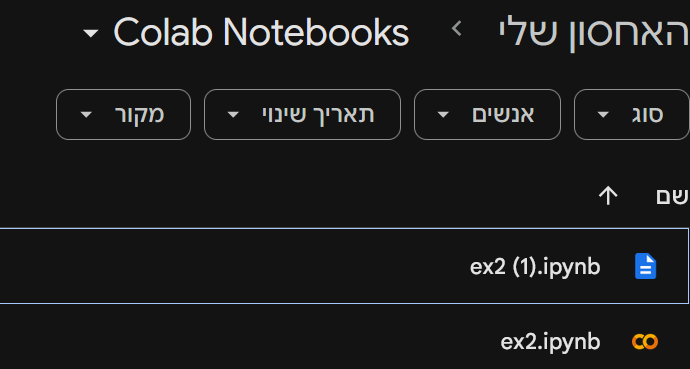
<br>
imports and version specifications.

In [3]:
# Installation of specific versions and libraries.
!pip install scikit-learn==1.2.0
!pip install xgboost==1.6.0
!pip install holidays
!pip install efficient_apriori
!pip install imbalanced-learn==0.10.0
%matplotlib inline


#imports
import shap
import xgboost as xgb
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor

import scipy as sp
from scipy import stats
from scipy.stats import pearsonr

import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression

import holidays

from efficient_apriori import apriori

import warnings
warnings.filterwarnings("ignore")

In [4]:

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
dtf = pd.read_csv("/content/drive/My Drive/ColabNotebooks/adc.csv", index_col='id')

In [6]:
cols = ["FL_DATE", "AIRLINE", "AIRLINE_DOT", "AIRLINE_CODE", "DOT_CODE", "FL_NUMBER", "ORIGIN", "ORIGIN_CITY", "DEST", "DEST_CITY", "CRS_DEP_TIME", "DEP_TIME", "DEP_DELAY", "TAXI_OUT", "WHEELS_OFF", "WHEELS_ON", "TAXI_IN", "CRS_ARR_TIME", "ARR_TIME", "ARR_DELAY", "CANCELLED", "CANCELLATION_CODE", "DIVERTED", "CRS_ELAPSED_TIME", "ELAPSED_TIME", "AIR_TIME", "DISTANCE", "DELAY_DUE_CARRIER", "DELAY_DUE_WEATHER", "DELAY_DUE_NAS", "DELAY_DUE_SECURITY", "DELAY_DUE_LATE_AIRCRAFT"]
dtf = dtf[cols]
dtf.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
id,,,,,,,,,,,,,,,,,,,,,
1,01/09/2019,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0,186.0,176.0,153.0,1065,NaN,NaN,NaN,NaN,NaN
2,11/19/2022,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0,235.0,236.0,189.0,1399,NaN,NaN,NaN,NaN,NaN
3,7/22/2022,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0,118.0,112.0,87.0,680,NaN,NaN,NaN,NaN,NaN
4,03/06/2023,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0,260.0,285.0,249.0,1589,0.0,0.0,24.0,0.0,0.0
5,2/23/2020,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0,181.0,182.0,153.0,985,NaN,NaN,NaN,NaN,NaN


In [ ]:
dtf.describe()

,DOT_CODE,FL_NUMBER,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
count,1.048575e+06,1.048575e+06,1.048575e+06,1.021527e+06,1.021518e+06,1.021103e+06,1.021103e+06,1.020709e+06,1.020709e+06,1.048575e+06,...,1.048575e+06,1.048568e+06,1.018570e+06,1.018570e+06,1.048575e+06,187272.000000,187272.000000,187272.000000,187272.000000,187272.000000
mean,1.997643e+04,2.511431e+03,1.327044e+03,1.329752e+03,1.012276e+01,1.664025e+01,1.352444e+03,1.462485e+03,7.680054e+00,1.490744e+03,...,2.295496e-03,1.422071e+02,1.365674e+02,1.122599e+02,8.088263e+02,24.554957,3.928735,13.176700,0.147155,25.437866
std,3.773195e+02,1.746354e+03,4.860000e+02,4.994956e+02,4.885416e+01,9.208595e+00,5.010470e+02,5.273483e+02,6.274074e+00,5.115026e+02,...,4.785634e-02,7.151879e+01,7.166583e+01,6.973204e+01,5.876740e+02,70.935348,32.278717,32.977752,3.336814,55.378909
min,1.939300e+04,1.000000e+00,1.000000e+00,1.000000e+00,-8.200000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,2.000000e+01,1.500000e+01,8.000000e+00,2.900000e+01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.979000e+04,1.051000e+03,9.150000e+02,9.160000e+02,-6.000000e+00,1.100000e+01,9.310000e+02,1.049000e+03,4.000000e+00,1.107000e+03,...,0.000000e+00,9.000000e+01,8.400000e+01,6.100000e+01,3.770000e+02,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.993000e+04,2.152000e+03,1.320000e+03,1.323000e+03,-2.000000e+00,1.400000e+01,1.336000e+03,1.501000e+03,6.000000e+00,1.516000e+03,...,0.000000e+00,1.250000e+02,1.200000e+02,9.500000e+01,6.510000e+02,4.000000,0.000000,0.000000,0.000000,0.000000
75%,2.036800e+04,3.796000e+03,1.730000e+03,1.739000e+03,6.000000e+00,1.900000e+01,1.753000e+03,1.909000e+03,9.000000e+00,1.919000e+03,...,0.000000e+00,1.720000e+02,1.670000e+02,1.420000e+02,1.045000e+03,23.000000,0.000000,17.000000,0.000000,30.000000
max,2.045200e+04,9.562000e+03,2.359000e+03,2.400000e+03,2.690000e+03,1.840000e+02,2.400000e+03,2.400000e+03,2.490000e+02,2.400000e+03,...,1.000000e+00,6.950000e+02,7.220000e+02,6.670000e+02,5.812000e+03,2685.000000,1398.000000,1468.000000,377.000000,2096.000000


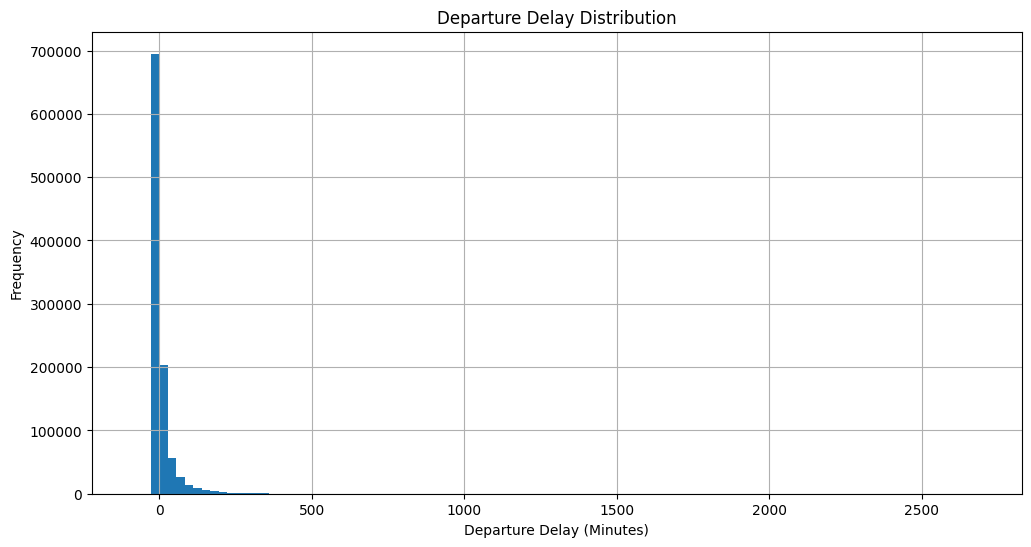

In [ ]:
dtf['DEP_DELAY'].hist(bins=100, figsize=(12, 6))
plt.title("Departure Delay Distribution")
plt.xlabel("Departure Delay (Minutes)")
plt.ylabel("Frequency")
plt.show()

<Axes: xlabel='DEP_DELAY', ylabel='Density'>

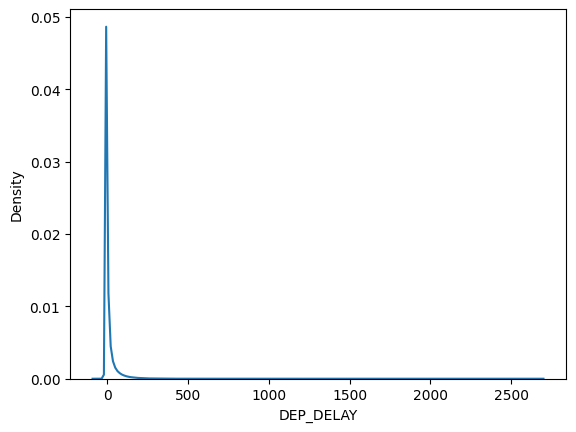

In [ ]:
sns.kdeplot(dtf.DEP_DELAY)

## 0) Old Model:

As we remember, we had several errors in the research:
First one was the actual delays versus the predictions: 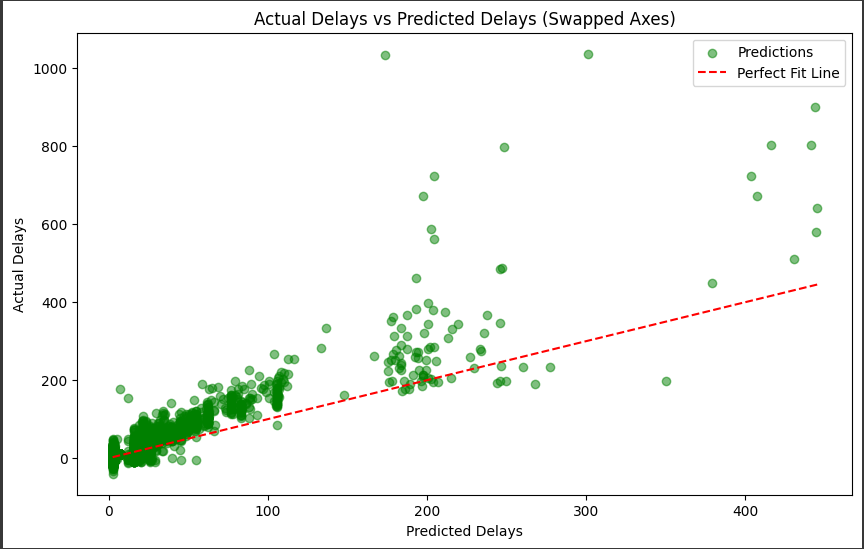

We also had boxplots for each month, representing the different quadrants & medians:
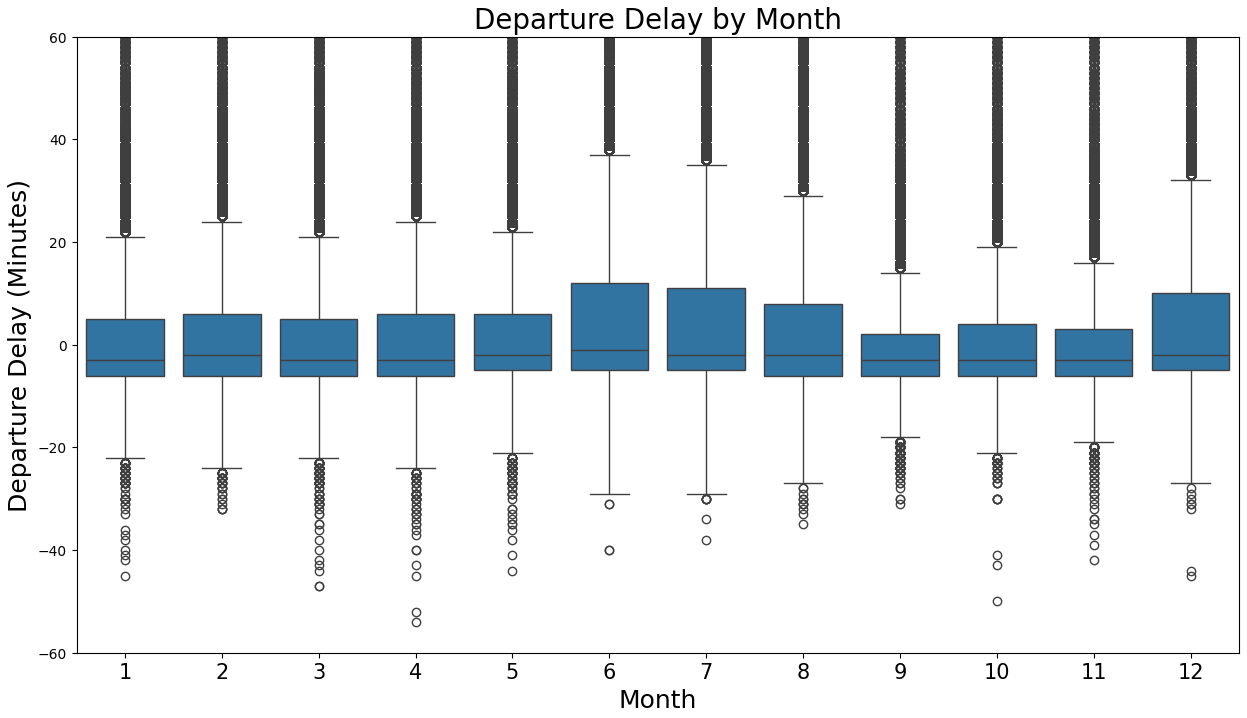

As we recall, this was the previous model pipeline:

In [ ]:
# Process categorical data (one-hot encoding)
df_processed = pd.get_dummies(dtf, columns=['ARR_DELAY'], drop_first=True)

# Reduce the dataset size for faster processing (use 5% of the data)
df_processed = df_processed.sample(frac=0.05, random_state=42)  # Use 5% of the data

# Handle datetime column separately
if 'FL_DATE' in df_processed.columns:
    # Convert FL_DATE to datetime, coercing errors to NaT
    df_processed['FL_DATE'] = pd.to_datetime(df_processed['FL_DATE'], errors='coerce')

    # Check for any NaT values, and giving them default dates.
    if df_processed['FL_DATE'].isna().sum() > 0:
        print(f"Found {df_processed['FL_DATE'].isna().sum()} invalid date entries. Filling with a default date.")
        df_processed['FL_DATE'].fillna(pd.Timestamp('1900-01-01'), inplace=True)

    # Extract time fields
    df_processed['year'] = df_processed['FL_DATE'].dt.year
    df_processed['month'] = df_processed['FL_DATE'].dt.month
    df_processed['day'] = df_processed['FL_DATE'].dt.day
    df_processed['hour'] = df_processed['FL_DATE'].dt.hour
    df_processed['minute'] = df_processed['FL_DATE'].dt.minute
    df_processed['weekday'] = df_processed['FL_DATE'].dt.weekday

    # Drop the original datetime column
    df_processed.drop(columns=['FL_DATE'], inplace=True)


X = df_processed.drop(['DEP_DELAY'], axis=1)
y = df_processed['DEP_DELAY']

# Handle missing values in the target variable
y_imputer = SimpleImputer(strategy='mean') # Imputations using the mean values
y = y_imputer.fit_transform(y.values.reshape(-1, 1)).ravel()

# Separate categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['number']).columns

# Impute missing values for categorical columns using the most frequent strategy
categorical_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = categorical_imputer.fit_transform(X[categorical_cols])

# Impute missing values for numeric columns using the mean strategy
numeric_imputer = SimpleImputer(strategy='mean')
X[numeric_cols] = numeric_imputer.fit_transform(X[numeric_cols])

# Handle all NaNs
assert not X.isnull().values.any(), "Imputation failed! X still contains NaN values."

# Convert categorical columns to numeric using LabelEncoder
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Convert all features to float32 for efficiency
X = X.astype('float32')

# Check for missing values in y
assert not np.isnan(y).any(), "y contains NaN values!"

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01],
    'subsample': [0.8]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform RandomizedSearchCV to find the best model
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist,
                                   n_iter=5, cv=3, scoring='r2', verbose=1,
                                   random_state=42, n_jobs=-1, error_score='raise')

# Check if RandomizedSearchCV works without errors
try:
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    # Make predictions
    y_pred = best_model.predict(X_test)
    print(f"R^2 Score: {r2_score(y_test, y_pred)}")
except ValueError as e:
    print(f"Error during training: {e}")
    # Fallback to a simpler model fit (w/out hyperparameter tuning)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    print(f"R^2 Score (fallback): {r2_score(y_test, y_pred)}")


Fitting 3 folds for each of 4 candidates, totalling 12 fits
R^2 Score: 0.7829277353780926


We also presented some data in numbers, not in graphs.
The first was over estimation vs. underestimation:

<u> Overestimation Percentage:</u> 71.70%

<u> Underestimation Percentage:</u> 28.30%
On this run we get 0.78.
And R^2 Score: (According to prev. model, not this run):
$$ R^2 = 0.7139785115014037 $$

However, we'll still improve it.

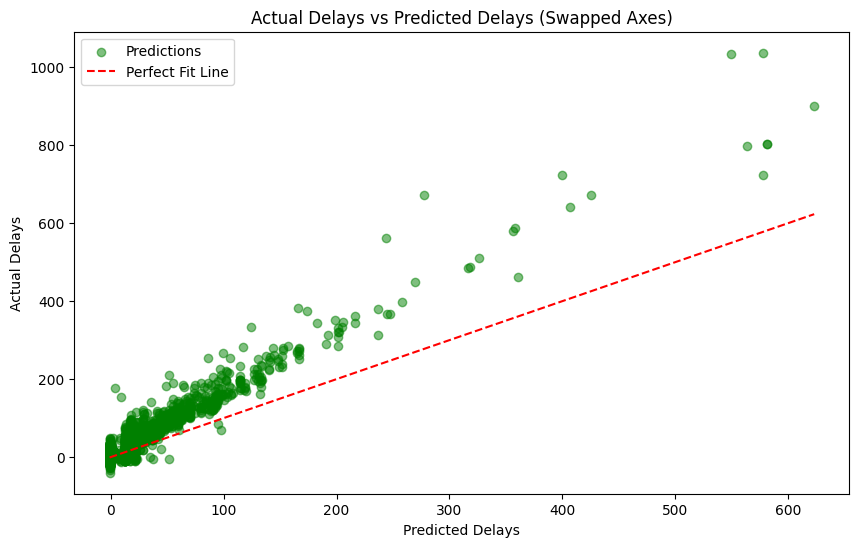

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_test, alpha=0.5, color='green', label='Predictions')
plt.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], color='red', linestyle='--', label='Perfect Fit Line')
plt.title('Actual Delays vs Predicted Delays (Swapped Axes)')
plt.xlabel('Predicted Delays')
plt.ylabel('Actual Delays')
plt.legend()
plt.show()

Samples pretty much overshoot the PFL.

Next, we had MSE for delay ranges 0-50, 51-100, etc. etc.<br>
<u> MSE for delay range 0-50</u>: 110.58078912404112 <br>
<u> MSE for delay range 50-100</u>: 1124.384275619585<br>
<u> MSE for delay range 150-200</u>: 5749.778295881085<br>
<u> MSE for delay range 100-150</u>: 2987.512563060832<br>
<u> MSE for delay range 200-250</u>: 5270.45192263196<br>
<u> MSE for delay range 300-350</u>: 20705.001219063546<br>
<u> MSE for delay range 250-300</u>: 9728.402248649209<br>
<u> MSE for delay range 350-400</u>: 34290.379822855655<br>
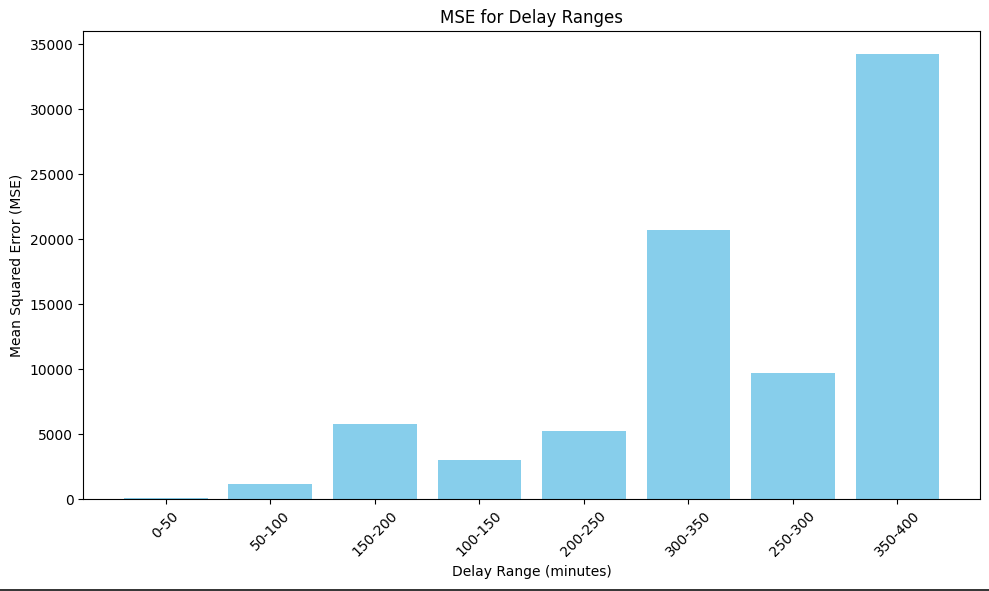

The line represents perfect fit, comparing actual delays versus predicted delays. The closer the points are to the line, the better the prediction is relating to the truth - the error is smaller.

The model works better with lower delays (0-100 minutes)

the model lacks performance with higher delays (>=101).

There are less delays which are big delays, so the prediction is working worse on those ranges. We an see there's a bias in the bigger delays, the bias is growing to the positive values (predicts higher delay than the truth).

RMSE: 21.416027636889066


 99%|===================| 52093/52429 [02:27<00:00]       

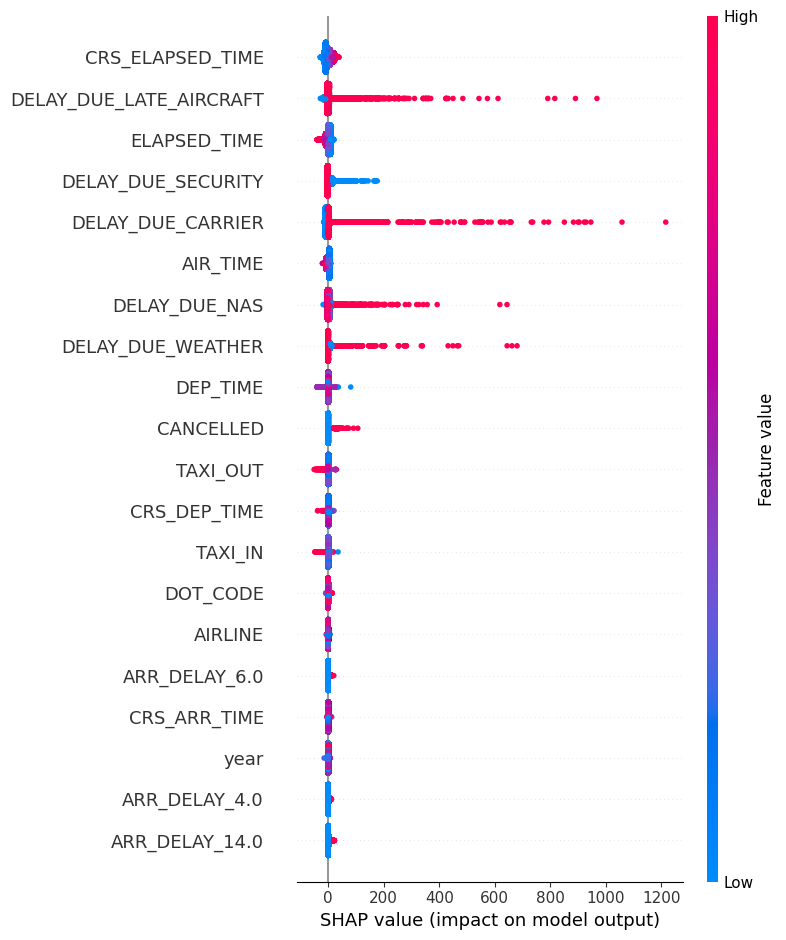

In [ ]:
# Calculate RMSE (Root Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error for regression
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Train an XGBoost model
model = xgb.XGBRegressor(random_state=42)
model.fit(X, y)

# Initialize SHAP explainer
explainer = shap.Explainer(model, X)

# Calculate SHAP values
shap_values = explainer(X)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X)


A big impact is caused by arrival delays -> which affects departure delays.
<br>
In air traffic, tracking elapsed time is crucial for ensuring that clearances, instructions, and flight progressions are happening as expected, maintaining safety, and avoiding delays or conflicts.
So, some reasons can be more technical, as CRS explains.
Most of the values are around 0-250. The ones painted red are the ones which have big impact on performance of the flight delays in departure.

Lets some information about correlation between ARR_DELAY and DEP_DELAY.
First, correlation coef:

In [ ]:
Xcol = 'ARR_DELAY'
Ycol = 'DEP_DELAY'
X = dtf[Xcol]
Y = dtf[Ycol]
r = X.corr(Y)
r


0.9642774603614287

0.96 correlation is lit, it means that flight arrival delays are impacted ALOT by departure delays.<br>
Next - coef. and intercept values.


In [ ]:

X = X.values.reshape(-1, 1)

# Replace NaN values in X with the mean
imputer_X = SimpleImputer(strategy='mean')
X = imputer_X.fit_transform(X)

# Replace NaN values in Y with the mean
imputer_Y = SimpleImputer(strategy='mean')
Y = imputer_Y.fit_transform(Y.values.reshape(-1, 1)).ravel()

model = LinearRegression()
y_pred = model.fit(X, Y).predict(X)

# Retrieve coefficients and intercept
coef = model.coef_
intercept = model.intercept_

print("Intercept:", intercept)
print("Coefficient:", coef)


Intercept: 6.187547278743333
Coefficient: [0.923301]


for every one-unit increase in XX, YY increases by approximately 0.9233.
And for X=0, Y=6.18.
Therefore,

$$
Y=6.1875+0.9233⋅X
$$

We'll see that heatmap, which tells us what features are co-linear, which is good for us.
In our linear regression model. And standard deviations are:

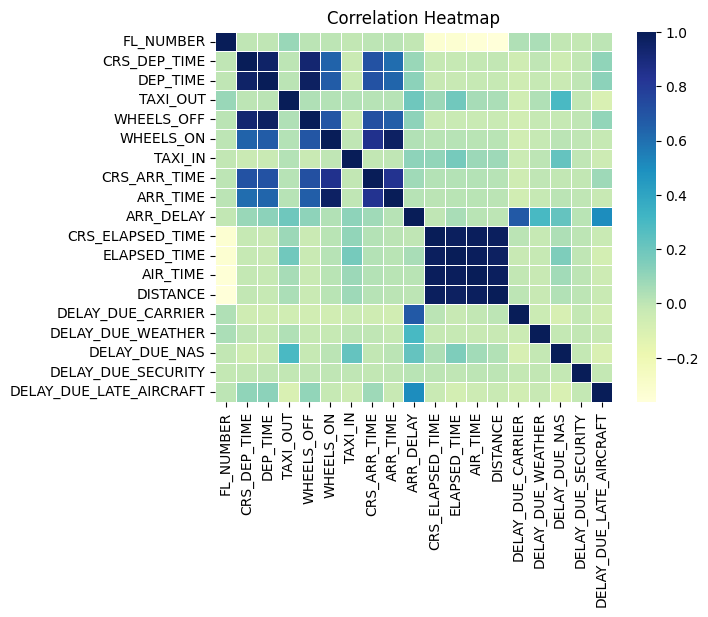

In [ ]:
numeric_columns = dtf.dtypes[(dtf.dtypes=="float64") | (dtf.dtypes=="int64")].index.tolist()
very_numerical = [nc for nc in numeric_columns if dtf[nc].nunique()>20]
X = dtf[very_numerical].drop(Ycol,axis=1)

X_corr = X.corr()

# Plot the heatmap
sns.heatmap(X_corr, annot=False, fmt='.2f', cmap="YlGnBu", cbar=True, linewidth=0.5)
plt.title("Correlation Heatmap")
plt.show()


We see a massive chunk with DISTANCE, AIR_TIME, ELAPSED_TIME, CRS_ELAPSED_TIME which got high correlation, along with other values that we can see that have a slightly lower correlation, but still pretty high.

Now we want to check which two features have high correlation, which dont and be able to analyze the dataset and more/less valued features.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              DEP_DELAY   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                          1.901e+06
Date:                Sun, 19 Jan 2025   Prob (F-statistic):                        0.00
Time:                        14:04:56   Log-Likelihood:                     -3.7038e+06
No. Observations:             1048575   AIC:                                  7.408e+06
Df Residuals:                 1048556   BIC:                                  7.408e+06
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
FL_NUMBER                   0.0001   4.94e-06     24.893      0.000       0.000       0.000
CRS_DEP_TIME               -0.0004   5.14e-05     -8.700      0.000      -0.001      -0.000
DEP_TIME                    0.0028    8.2e-05     34.329      0.000       0.003       0.003
TAXI_OUT                    0.2026      0.009     21.807      0.000       0.184       0.221
WHEELS_OFF                 -0.0013   6.96e-05    -18.230      0.000      -0.001      -0.001
WHEELS_ON                  -0.0007   6.14e-05    -11.993      0.000      -0.001      -0.001
TAXI_IN                     0.2113      0.009     22.687      0.000       0.193       0.230
CRS_ARR_TIME                0.0008   3.24e-05     24.751      0.000       0.001       0.001
ARR_TIME                   -0.0004   5.82e-05     -6.185      0.000      -0.000      -0.000
ARR_DELAY                   0.9201      0.000   3459.438      0.000       0.920       0.921
CRS_ELAPSED_TIME            0.5321      0.001    723.751      0.000       0.531       0.534
ELAPSED_TIME               -1.0122      0.009   -108.898      0.000      -1.030      -0.994
AIR_TIME                    0.6492      0.009     69.607      0.000       0.631       0.668
DISTANCE                   -0.0193   7.74e-05   -249.794      0.000      -0.019      -0.019
DELAY_DUE_CARRIER           0.0907      0.000    248.576      0.000       0.090       0.091
DELAY_DUE_WEATHER           0.0813      0.001    126.575      0.000       0.080       0.083
DELAY_DUE_NAS               0.0097      0.001     15.564      0.000       0.008       0.011
DELAY_DUE_SECURITY          0.1022      0.006     17.822      0.000       0.091       0.113
DELAY_DUE_LATE_AIRCRAFT     0.0973      0.000    234.077      0.000       0.097       0.098
==============================================================================
Omnibus:                  2409633.598   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     218985300001.080
Skew:                          21.318   Prob(JB):                         0.00
Kurtosis:                    2241.384   Cond. No.                     1.04e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

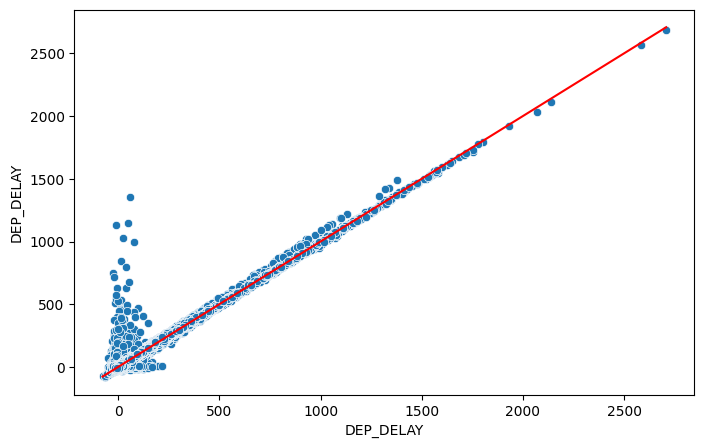

In [ ]:
numeric_columns = dtf.dtypes[(dtf.dtypes=="float64") | (dtf.dtypes=="int64")].index.tolist()
very_numerical = [nc for nc in numeric_columns if dtf[nc].nunique()>20]
categorical_columns = [c for c in dtf.columns if c not in numeric_columns]
ordinals = list(set(numeric_columns) - set(very_numerical))

na_columns = dtf[very_numerical].isna().sum()
na_columns = na_columns[na_columns>0]
for nc in na_columns.index:
    dtf[nc].fillna(dtf[nc].mean(),inplace=True)

nul_cols = dtf[categorical_columns].isna().sum()/len(dtf)
drop_us = nul_cols[nul_cols>0.7]

dtf=dtf.drop(drop_us.index,axis=1)
categorical_columns = list(set(categorical_columns)-set(drop_us.index))

dtf[categorical_columns]= dtf[categorical_columns].fillna('na')

Y= dtf[Ycol]
X = dtf[very_numerical].drop(Ycol,axis=1)
sk_ols_model = LinearRegression()
Y_pred = sk_ols_model.fit(X,Y).predict(X)

sm_model = sm.OLS(Y, X)
results = sm_model.fit()

Y_pred2 = results.fittedvalues

fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x=Y_pred2, y=Y, ax=ax)
sns.lineplot(x=Y_pred2, y=Y_pred2, ax=ax, color='red')

ax.set_xlabel("DEP_DELAY")
results.summary()

We might have a strong co-linearity which seems true, since we've seen the big blue chunk above with 4 different features. Lets check everything that has high co-linearity.

In [ ]:
high_corr = X_corr[X_corr>0.75]
high_corr.stack()

FL_NUMBER                FL_NUMBER                  1.000000
CRS_DEP_TIME             CRS_DEP_TIME               1.000000
                         DEP_TIME                   0.954566
                         WHEELS_OFF                 0.927001
DEP_TIME                 CRS_DEP_TIME               0.954566
                         DEP_TIME                   1.000000
                         WHEELS_OFF                 0.970253
TAXI_OUT                 TAXI_OUT                   1.000000
WHEELS_OFF               CRS_DEP_TIME               0.927001
                         DEP_TIME                   0.970253
                         WHEELS_OFF                 1.000000
WHEELS_ON                WHEELS_ON                  1.000000
                         CRS_ARR_TIME               0.850502
                         ARR_TIME                   0.963334
TAXI_IN                  TAXI_IN                    1.000000
CRS_ARR_TIME             WHEELS_ON                  0.850502
                         CRS_ARR_TIME               1.000000
                         ARR_TIME                   0.839629
ARR_TIME                 WHEELS_ON                  0.963334
                         CRS_ARR_TIME               0.839629
                         ARR_TIME                   1.000000
ARR_DELAY                ARR_DELAY                  1.000000
CRS_ELAPSED_TIME         CRS_ELAPSED_TIME           1.000000
                         ELAPSED_TIME               0.982349
                         AIR_TIME                   0.989192
                         DISTANCE                   0.982457
ELAPSED_TIME             CRS_ELAPSED_TIME           0.982349
                         ELAPSED_TIME               1.000000
                         AIR_TIME                   0.987699
                         DISTANCE                   0.969473
AIR_TIME                 CRS_ELAPSED_TIME           0.989192
                         ELAPSED_TIME               0.987699
                         AIR_TIME                   1.000000
                         DISTANCE                   0.983839
DISTANCE                 CRS_ELAPSED_TIME           0.982457
                         ELAPSED_TIME               0.969473
                         AIR_TIME                   0.983839
                         DISTANCE                   1.000000
DELAY_DUE_CARRIER        DELAY_DUE_CARRIER          1.000000
DELAY_DUE_WEATHER        DELAY_DUE_WEATHER          1.000000
DELAY_DUE_NAS            DELAY_DUE_NAS              1.000000
DELAY_DUE_SECURITY       DELAY_DUE_SECURITY         1.000000
DELAY_DUE_LATE_AIRCRAFT  DELAY_DUE_LATE_AIRCRAFT    1.000000
dtype: float64

We see that some items do have co-linearity for obviouse reasons.
Distance w. elapsed time, air time, crs elapsed time. Seems normal.
We get too many duplicates, so lets get rid of them and see what's next:

In [ ]:
hc = high_corr.stack().reset_index()
hc.columns=["col1","col2","corr"]
hc[hc.col1!=hc.col2]

,col1,col2,corr
2,CRS_DEP_TIME,DEP_TIME,0.954566
3,CRS_DEP_TIME,WHEELS_OFF,0.927001
4,DEP_TIME,CRS_DEP_TIME,0.954566
6,DEP_TIME,WHEELS_OFF,0.970253
8,WHEELS_OFF,CRS_DEP_TIME,0.927001
9,WHEELS_OFF,DEP_TIME,0.970253
12,WHEELS_ON,CRS_ARR_TIME,0.850502
13,WHEELS_ON,ARR_TIME,0.963334
15,CRS_ARR_TIME,WHEELS_ON,0.850502
17,CRS_ARR_TIME,ARR_TIME,0.839629


Time to check which values do the inflation factor, for VIF value to be larger than 10 provides us a hint that the feature can be removed from the dataset as it doesnt bring us more to the table. Lets dive into the value:
- VIF = 1: No correlation with other features. We need those features.
- 1 < VIF < 5: Low correlation with other features.
- VIF ≥ 5: High correlation, indicating multicollinearity. These can be removed.

In [ ]:
vif_dict = {}
for i, name in enumerate(X.columns):
    v = variance_inflation_factor(X.values,i)
    vif_dict[name]=v.round()
vifs = pd.Series(vif_dict)
vifs.sort_values()

,0
DELAY_DUE_WEATHER,1.0
DELAY_DUE_SECURITY,1.0
DELAY_DUE_NAS,2.0
FL_NUMBER,3.0
DELAY_DUE_CARRIER,3.0
ARR_DELAY,3.0
DELAY_DUE_LATE_AIRCRAFT,3.0
CRS_ARR_TIME,40.0
CRS_DEP_TIME,81.0
DISTANCE,92.0


So now we can see which features we can get rid off, all the ones that are CRS_ARR_TIME and below it.

The features with co-linearity have high corr. values, over than 0.8,
and others are closing in to 1.0.

Let's investigate the co-linearity of AIR_TIME with other features.


In [ ]:
vif_c = "AIR_TIME"
z = dtf[vif_c]
Xv = X.drop(vif_c,axis=1)

In [ ]:
# Training model on DEP_DELAY and check non-zero co-eff.
modelv = sm.OLS(z, Xv)
results = modelv.fit()


In [ ]:
r= results.params.round()
r = r[r.abs()>0]
r


,0
TAXI_OUT,-1.0
TAXI_IN,-1.0
ELAPSED_TIME,1.0


So, the line should be this formula:
$$
AIR.TIME = -(TAXI.OUT)-(TAXI.IN)+(ELAPSED.TIME)
$$

And here are some examples that can be calculated, and the results are not far off...

In [ ]:
dtf[r.index.tolist()+[vif_c]].head()

,TAXI_OUT,TAXI_IN,ELAPSED_TIME,AIR_TIME
id,,,,
1,19.0,4.0,176.0,153.0
2,9.0,38.0,236.0,189.0
3,20.0,5.0,112.0,87.0
4,27.0,9.0,285.0,249.0
5,15.0,14.0,182.0,153.0


Lets see results with statistics we've seen before - Manibus Test, AIC, BIC etc.

- **AIC**: AIC is used for model selection. It penalizes models that use more parameters, thus helping to prevent overfitting.
Lower AIC values indicate a better-fitting model. So we want to minimize it.
$$
AIC=2k−2ln(L)
$$
<br>

k = the number of parameters in the model.<br>
L = the likelihood of the model.
<br><br>

- **BIC**: Similar to AIC, but with a stronger penalty for adding parameters to the model. BIC is derived from the likelihood function, just like AIC, but includes a different penalty for the number of parameters.<br>
Lower BIC values indicate a better-fitting model.
$$
BIC=ln(n)k−2ln(L)
$$
<br>
n = number of observations (data points).<br>
k = number of parameters.<br>
L = likelihood of the model.<br>

- **Omnibus Test**: The Omnibus test is a test of the overall significance of the regression model. It checks whether at least one of the predictors (independent variables) has a non-zero coefficient.<br>
A significant p-value (typically < 0.05) from the Omnibus test indicates that the model as a whole fits the data significantly better than a model with no predictors.

- **F-Statistics**: Tests whether the model explains a significant portion of the variance in the data, comparing it against an intercept-only model.

### <u> So, what might've caused errors? </u>

- There was alot of data. As you can recall, we used a small part of it, in order to use less RAM that we were pretty limited with. The random selection of data sampling might change accuracy if choosing different ratio of delays in relation with original dataset.
Note that working on all of data is ***VERY*** time consuming task. One run of it took over than 3 hours and didnt finish.
Even though we test the models on much smaller sample space, changing the line from sampling into dtf.copy() can provide you with the whole sample space. However due to time limitations it isn't really a good idea for us.

- Considering the previous point, we might have selected randomly, extreme values which might not represent the dataset.

- For some airports, there might be less samples than it should, misrepresenting/interpreting them.

- Underfitting: We have too little amount of data, a classic reason for underfit.

- Trends/Patters we need to consider, such as Covid-19 and holidays, which also might change performances of airports/airlines.

- External factors: strikes, sudden weather changes, operational updates, etc.

- Using MSE alone might not reflect the business impact of errors. Example could be predicting 10 minutes of delay when its just 2 minutes, or to the worse case - an hour.
<br>

### <u> Possible Solutions </u>

- Improve data processing, to prevent overuse of RAM sources, in order to work on as much as data as we can. It is pretty general, so more explanation will be given in the process itself, and how it was conducted.

- The above solution also solves this issue. If we can work on most of the data, or even all of it, then the problem is minimized or will not even exist.

- SAME. Or, select a representing amounts from each airports, to keep the ratio of flights from each one.

- Increase model complexity or use ensemble methods like gradient boosting.

- For trends, Patterns or other external factors, we can:

    1) Use time-series features such as "month," "day of the week," or "time of day."

    2) Train separate models for different seasons or times of the day.

    3) Use external datasets that capture broader contextual factors (e.g.,    national holiday schedules, airport traffic).

- Use metrics like RMSE, MAE, or custom metrics that prioritize prediction accuracy for significant delays & evaluate performance across subgroups (short vs. long delays).

<br>
For understimation and other issues, we can use ensemble models like Random Forest, Gradient Boosting, or XGBoost, which handle non-linear relationships well / Use Quantile Loss to focus on under-predicted regions / Hyperparameter tuning & feature engineering as well (adding features or transformation of existing features). <br><br> In the original dataset, some of the samples had missing values for features, so we'll need to fil them up, using median values/mean/regression based values.
<br><br>
Each new model will have several stats that will be compared:

- MSE
- R^2
- Over/underestimation percentage
- Prediction vs. Actual delay & Perfect Fit line
- Pearson Correlation
- RMSE
- SHAP

Note that we import specific version of libraries for the models, in order to prevent mismatching of libraries and functionalities:

scikit-learn v1.2.0<br>
xgboost v1.6.0

## **1) Model I**

Using the above mentioned techniques, and more, we'll try to improve the model.<br>
The first idea can be using <u>more data</u> in order to achieve more accuracy.
Recall that we used less data (5% of original dataset) because of technical issues. Let's give it a shot.

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import xgboost as xgb

# Use the entire dataset (assuming 'dtf' is already loaded)
df_processed = dtf.copy()  # Use the full dataset

# Handle datetime column
if 'FL_DATE' in df_processed.columns:
    df_processed['FL_DATE'] = pd.to_datetime(df_processed['FL_DATE'])
    df_processed['year'] = df_processed['FL_DATE'].dt.year
    df_processed['month'] = df_processed['FL_DATE'].dt.month
    df_processed['day'] = df_processed['FL_DATE'].dt.day
    df_processed['hour'] = df_processed['FL_DATE'].dt.hour
    df_processed['minute'] = df_processed['FL_DATE'].dt.minute
    df_processed['weekday'] = df_processed['FL_DATE'].dt.weekday
    df_processed.drop(columns=['FL_DATE'], inplace=True)

# Define target variable and features
X = df_processed.drop(['DEP_DELAY'], axis=1)
y = df_processed['DEP_DELAY']

# Handle missing values in the target variable
y_imputer = SimpleImputer(strategy='mean')
y = y_imputer.fit_transform(y.values.reshape(-1, 1)).ravel()

# Separate categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['number']).columns

# Impute missing values for categorical columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = categorical_imputer.fit_transform(X[categorical_cols])

# Impute missing values for numeric columns
numeric_imputer = SimpleImputer(strategy='mean')
X[numeric_cols] = numeric_imputer.fit_transform(X[numeric_cols])

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Ensure all features are numerical and convert to float32
X = X.astype('float32')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01],
    'subsample': [0.8]
}

# Define the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Wrap the model in a compatible scikit-learn wrapper
xgb_model_sklearn = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=100,
    verbosity=0
)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model_sklearn,
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=-1,
    error_score='raise'
)

# Train the model with error handling
try:
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print(f"Best Parameters: {random_search.best_params_}")
    print(f"R^2 Score: {r2_score(y_test, y_pred)}")
except Exception as e:
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    print(f"R^2 Score (fallback): {r2_score(y_test, y_pred)}")


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01}
R^2 Score: 0.8210153962736971


We can see a high R^2 score now: 0.82, a small improvement. <br>
Let's try predicting values:

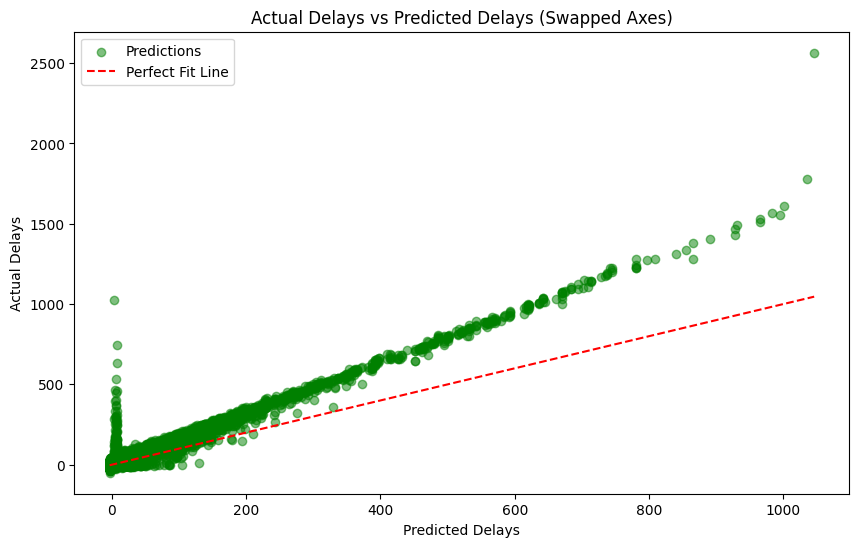

In [ ]:
residuals = y_test - y_pred
# Actual Delays vs Predicted Delays (Swapped Axes)
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_test, alpha=0.5, color='green', label='Predictions')
plt.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], color='red', linestyle='--', label='Perfect Fit Line')
plt.title('Actual Delays vs Predicted Delays (Swapped Axes)')
plt.xlabel('Predicted Delays')
plt.ylabel('Actual Delays')
plt.legend()
plt.show()

We can see that the predictions are closer to the perfect fit line, but still overshooting. <br> with much less deviations in comparison to amount of samples.<br> The deviations are now more in line.

Let's take a look at the MSE for same differences and the over/underestimation errors:

MSE for delay range 0-50: 126.09717769435433
MSE for delay range 100-150: 2401.9937532641015
MSE for delay range 50-100: 902.0409553747617
MSE for delay range 200-250: 7891.363135602453
MSE for delay range 300-350: 16145.604881291476
MSE for delay range 150-200: 4733.056127965911
MSE for delay range 250-300: 11988.06588974014
MSE for delay range 350-400: 22304.768726752874


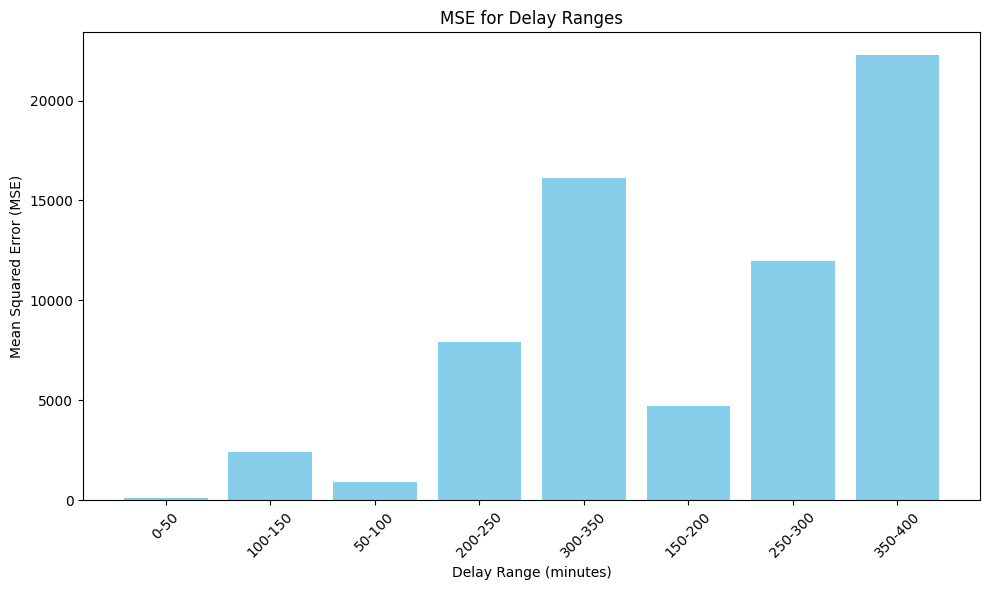

In [ ]:


# Define the bins for delays (0-50, 50-100 ...)
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400]

# Create a new column in the data that categorizes delays into bins
df_processed['delay_range'] = pd.cut(df_processed['DEP_DELAY'], bins=bins, labels=[f'{x}-{y}' for x, y in zip(bins[:-1], bins[1:])])

# Initialize a dictionary to store MSE values for each delay range
mse_dict = {}

# Loop through each bin and calculate the MSE for each range
for delay_range in df_processed['delay_range'].unique():
    bin_indices = df_processed['delay_range'] == delay_range
    X_bin = X[bin_indices]
    y_bin = y[bin_indices]

    if len(y_bin) > 0:
        # Make predictions using the best model (or fallback model if necessary)
        y_pred_bin = best_model.predict(X_bin) if 'best_model' in locals() else xgb_model.predict(X_bin)

        mse = mean_squared_error(y_bin, y_pred_bin)
        mse_dict[delay_range] = mse

# Print the MSE for each delay range
for delay_range, mse in mse_dict.items():
    print(f"MSE for delay range {delay_range}: {mse}")

# Plot the MSE for each range
ranges = list(mse_dict.keys())
mse_values = list(mse_dict.values())

plt.figure(figsize=(10, 6))
plt.bar(ranges, mse_values, color='skyblue')
plt.xlabel('Delay Range (minutes)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Delay Ranges')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We see that the total sum of MSEs is smaller than the total sums of MSEs in previous model - the sum of all of the current ones wont reach the MSE for delays of 250-300 minutes from prev. model, so that's an improvement as well. <br> What about over/under estimation?

In [ ]:
residuals = y_test - y_pred

# Calculate percentage of overestimations and underestimations
overestimation = np.sum(residuals < 0) / len(residuals) * 100
underestimation = np.sum(residuals > 0) / len(residuals) * 100

print(f"Overestimation Percentage: {overestimation:.2f}%")
print(f"Underestimation Percentage: {underestimation:.2f}%")


Overestimation Percentage: 56.13%
Underestimation Percentage: 43.87%


The over/under-estimations are more balanced now, around 50% and not 71.7% & 28.3%. <br>
It helps to reduce the bias of the model:
There are less samples which the model overestimating for, so there's less "force" used in the bias towards higher values, and more "force" for the lower values.
<br>It's also improving the model accuracy (less bias..), less accomulation errors, more fair model and better generalization - remember? less force for overestimation leads to less biasing, so there's less error in the generalization phase.

RMSE: 20.438480406878714


100%|===================| 1048245/1048575 [33:27<00:00]       

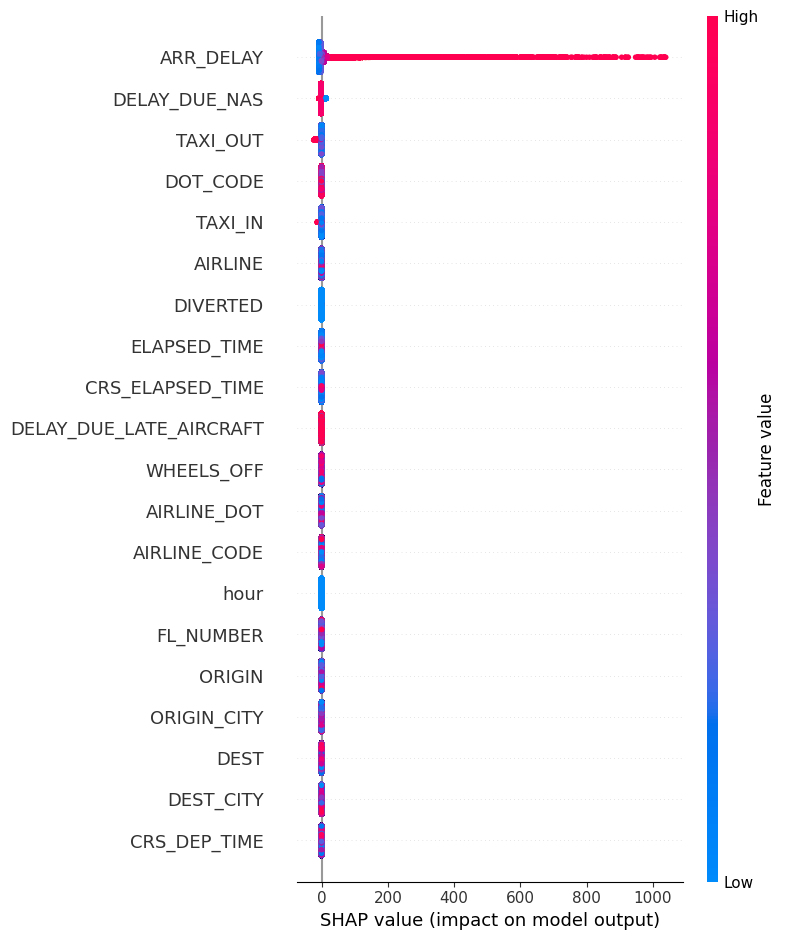

In [ ]:
# Calculate RMSE (Root Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error for regression
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Train an XGBoost model
#model = xgboost.XGBRegressor(random_state=42)
#model.fit(X, y)

# Initialize SHAP explainer
explainer = shap.Explainer(best_model, X)

# Calculate SHAP values
shap_values = explainer(X)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X)


A small improvement in RMSE as well.
There are less stranded dots like in the original model.


Now we will examine the Permutation Importance


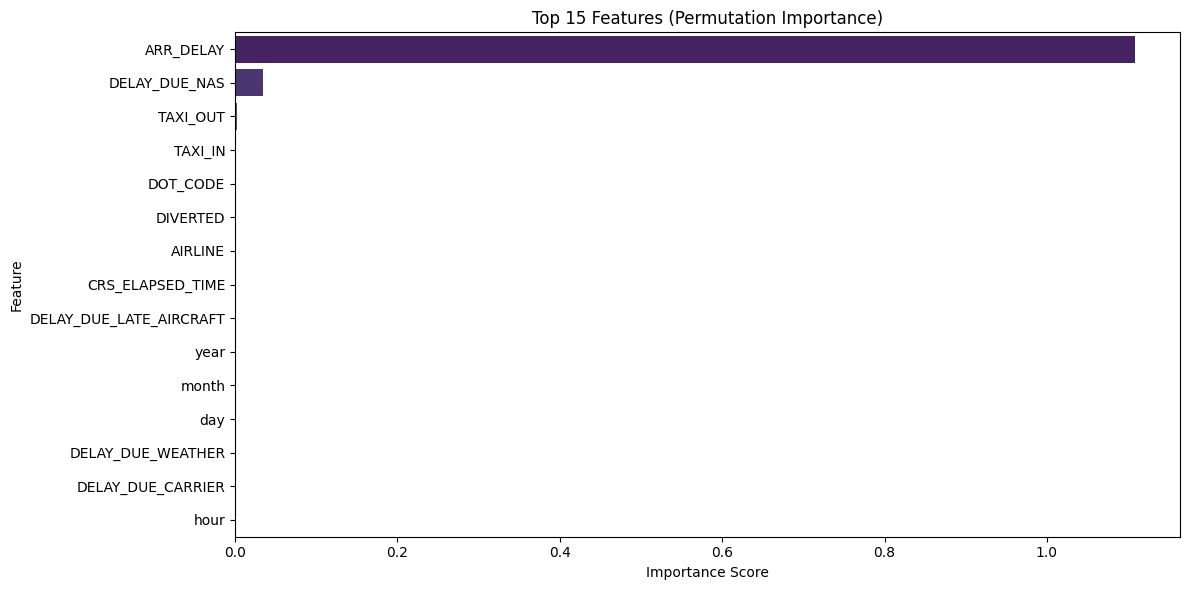


Top 10 Most Important Features:
                    Feature  Importance           Std
17                ARR_DELAY    1.108531  2.573203e-03
27            DELAY_DUE_NAS    0.034365  9.632615e-05
11                 TAXI_OUT    0.001979  4.025666e-05
14                  TAXI_IN    0.000423  1.092975e-05
3                  DOT_CODE    0.000241  2.619534e-06
20                 DIVERTED    0.000097  8.244013e-07
0                   AIRLINE    0.000021  2.465378e-07
21         CRS_ELAPSED_TIME    0.000003  1.131387e-07
29  DELAY_DUE_LATE_AIRCRAFT    0.000000  0.000000e+00
30                     year    0.000000  0.000000e+00


In [ ]:
# Permutation Importance Analysis
from sklearn.inspection import permutation_importance
import seaborn as sns

# Calculate permutation importance
perm_importance = permutation_importance(best_model, X_test, y_test,
                                       n_repeats=10,
                                       random_state=42)

# Create DataFrame of feature importance
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot permutation importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15),
            palette='viridis')
plt.title('Top 15 Features (Permutation Importance)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Print top features
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

Let's explain a bit.
The analysis uses permutation importance to assess each feature's impact on model performance. By shuffling each feature's values and measuring the drop in accuracy,
**the Importance score indicates how critical a feature is**
,with higher scores showing greater importance.
 Std shows the score's variability across multiple repetitions. The bar plot highlights the top 15 features, showing their relative importance, while the top 10 features list provides a quick summary of the most influential predictors.






Lets some information about correlation between ARR_DELAY and DEP_DELAY.
First, correlation coef:

In [ ]:
Xcol = 'ARR_DELAY'
Ycol = 'DEP_DELAY'
X = dtf[Xcol]
Y = dtf[Ycol]
r = X.corr(Y)
r


0.9642774603614287

Next - coef. and intercept values.


In [ ]:
# Convert X to a NumPy array and reshape it
X = X.values.reshape(-1, 1)

# Replace NaN values in X with the mean
imputer_X = SimpleImputer(strategy='mean')
X = imputer_X.fit_transform(X)

# Replace NaN values in Y with the mean
imputer_Y = SimpleImputer(strategy='mean')
Y = imputer_Y.fit_transform(Y.values.reshape(-1, 1)).ravel()

# Fit the linear regression model
model = LinearRegression()
y_pred = model.fit(X, Y).predict(X)

# Retrieve coefficients and intercept
coef = model.coef_
intercept = model.intercept_

print("Intercept:", intercept)
print("Coefficient:", coef)


Intercept: 6.187547278743333
Coefficient: [0.923301]


for every one-unit increase in XX, YY increases by approximately 0.9233.
And for X=0, Y=6.18.
Therefore,

$$
Y=6.1875+0.9233⋅X
$$

Is our linear regression model. And standard deviations are:

In [ ]:
X.std(),Y.std()

(50.0960073971892, 48.21971034443628)

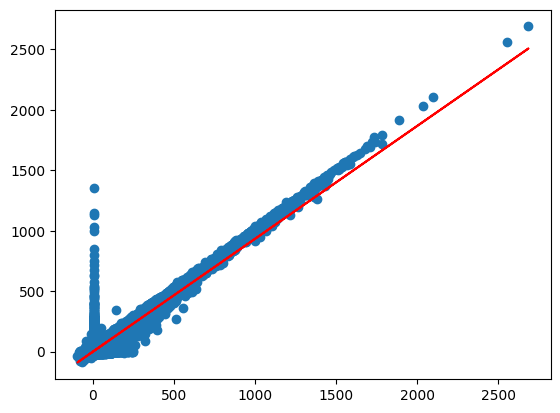

In [ ]:
model = sm.OLS(Y, X)
results = model.fit()
Y_pred = results.fittedvalues
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

The line could be better.

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.908
Model:                            OLS   Adj. R-squared (uncentered):              0.908
Method:                 Least Squares   F-statistic:                          1.033e+07
Date:                Sun, 19 Jan 2025   Prob (F-statistic):                        0.00
Time:                        21:30:53   Log-Likelihood:                     -4.3245e+06
No. Observations:             1048575   AIC:                                  8.649e+06
Df Residuals:                 1048574   BIC:                                  8.649e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9337      0.000   3213.760      0.000       0.933       0.934
==============================================================================
Omnibus:                  1134794.859   Durbin-Watson:                   1.662
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4890909985.277
Skew:                           4.211   Prob(JB):                         0.00
Kurtosis:                     337.475   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## **2) Model II**
Let's try and continue working on the smaller model, with different <u>hyper parameters</u> and iterations.

In [7]:
# Sample 5% of the dataset (assuming 'dtf' is already loaded)
df_processed = dtf.sample(frac=0.05, random_state=42)

# Handle datetime column
if 'FL_DATE' in df_processed.columns:
    df_processed['FL_DATE'] = pd.to_datetime(df_processed['FL_DATE'])
    df_processed['year'] = df_processed['FL_DATE'].dt.year
    df_processed['month'] = df_processed['FL_DATE'].dt.month
    df_processed['day'] = df_processed['FL_DATE'].dt.day
    df_processed['hour'] = df_processed['FL_DATE'].dt.hour
    df_processed['minute'] = df_processed['FL_DATE'].dt.minute
    df_processed['weekday'] = df_processed['FL_DATE'].dt.weekday
    df_processed.drop(columns=['FL_DATE'], inplace=True)

# Define target variable and features
X = df_processed.drop(['DEP_DELAY'], axis=1)
y = df_processed['DEP_DELAY']

# Handle missing values in the target variable
y_imputer = SimpleImputer(strategy='mean')
y = y_imputer.fit_transform(y.values.reshape(-1, 1)).ravel()

# Separate categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['number']).columns

# Impute missing values for categorical columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = categorical_imputer.fit_transform(X[categorical_cols])

# Impute missing values for numeric columns
numeric_imputer = SimpleImputer(strategy='mean')
X[numeric_cols] = numeric_imputer.fit_transform(X[numeric_cols])

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Ensure all features are numerical and convert to float32
X = X.astype('float32')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define an extended parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1],  # L1 regularization
    'reg_lambda': [1, 1.5, 2.0],  # L2 regularization
}

# Define the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,  # Increased iterations for broader exploration
    cv=3,
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=-1,
    error_score='raise'
)

# Train the model with error handling
try:
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print(f"Best Parameters: {random_search.best_params_}")
    print(f"R^2 Score: {r2_score(y_test, y_pred)}")
except Exception as e:
    print(f"Error: {e}")
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    print(f"R^2 Score (fallback): {r2_score(y_test, y_pred)}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
R^2 Score: 0.9832207761123414


R^2 score is now 0.98 - a big improvement.<br>
Using different and new items:
- learning rates
- L1 and L2 regularizations
- More iterations (20)

We reached better performance.

Now for MSE and over/underestimations:

MSE for delay range 0-50: 11.56604508696803
MSE for delay range 50-100: 18.508615361783665
MSE for delay range 150-200: 155.95564462645953
MSE for delay range 100-150: 34.664315159392984
MSE for delay range 200-250: 40.53151921268488
MSE for delay range 300-350: 60.91024117082082
MSE for delay range 250-300: 81.19395612958948
MSE for delay range 350-400: 256.8615640256181


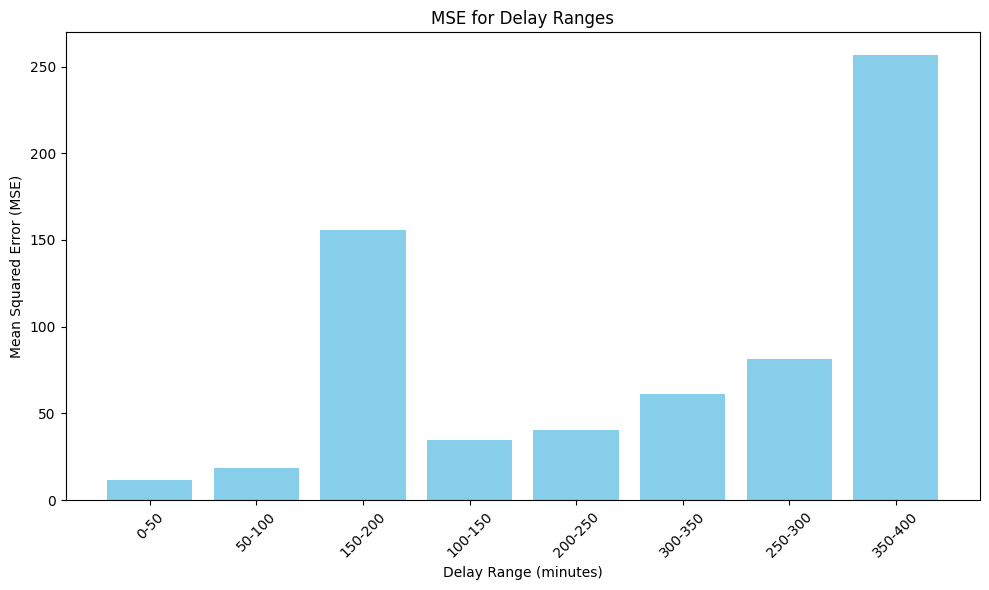

Overestimation Percentage: 52.70%
Underestimation Percentage: 47.30%


In [8]:

# Define the bins for delays (0-50, 50-100 ...)
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400]

# Create a new column in the data that categorizes delays into bins
df_processed['delay_range'] = pd.cut(df_processed['DEP_DELAY'], bins=bins, labels=[f'{x}-{y}' for x, y in zip(bins[:-1], bins[1:])])

# Initialize a dictionary to store MSE values for each delay range
mse_dict = {}

# Loop through each bin and calculate the MSE for each range
for delay_range in df_processed['delay_range'].unique():
    bin_indices = df_processed['delay_range'] == delay_range
    X_bin = X[bin_indices]
    y_bin = y[bin_indices]

    if len(y_bin) > 0:
        # Make predictions using the best model (or fallback model if necessary)
        y_pred_bin = best_model.predict(X_bin) if 'best_model' in locals() else xgb_model.predict(X_bin)

        mse = mean_squared_error(y_bin, y_pred_bin)
        mse_dict[delay_range] = mse

# Print the MSE for each delay range
for delay_range, mse in mse_dict.items():
    print(f"MSE for delay range {delay_range}: {mse}")

# Plot the MSE for each range
ranges = list(mse_dict.keys())
mse_values = list(mse_dict.values())

plt.figure(figsize=(10, 6))
plt.bar(ranges, mse_values, color='skyblue')
plt.xlabel('Delay Range (minutes)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Delay Ranges')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


residuals = y_test - y_pred

# Calculate percentage of overestimations and underestimations
overestimation = np.sum(residuals < 0) / len(residuals) * 100
underestimation = np.sum(residuals > 0) / len(residuals) * 100

print(f"Overestimation Percentage: {overestimation:.2f}%")
print(f"Underestimation Percentage: {underestimation:.2f}%")


The over/underestimations stay balanced, but we reached even lower MSE error in total. <br>Lets see what prediction gives us:

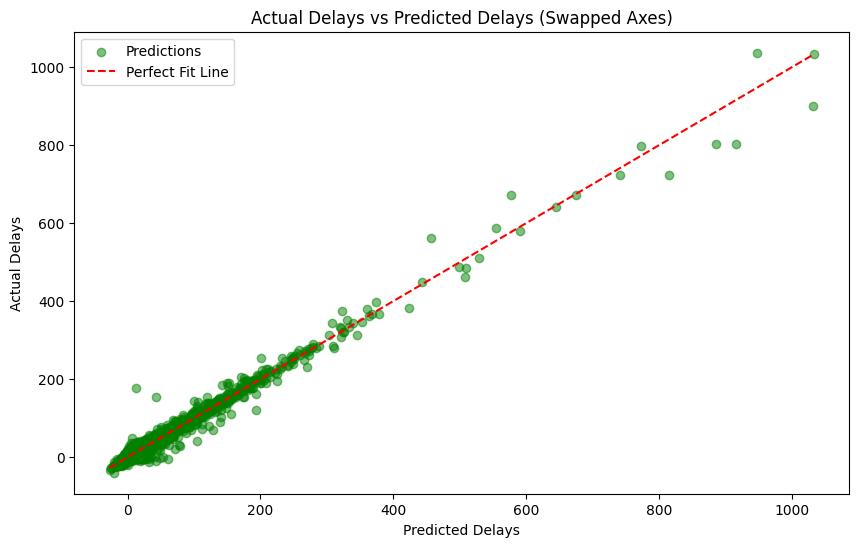

In [9]:
residuals = y_test - y_pred
# Actual Delays vs Predicted Delays (Swapped Axes)
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_test, alpha=0.5, color='green', label='Predictions')
plt.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], color='red', linestyle='--', label='Perfect Fit Line')
plt.title('Actual Delays vs Predicted Delays (Swapped Axes)')
plt.xlabel('Predicted Delays')
plt.ylabel('Actual Delays')
plt.legend()
plt.show()

Seems much better now, we got a better fit for the line, the best so far.

In [10]:
residuals = y_test - y_pred

verestimation = np.sum(residuals < 0) / len(residuals) * 100
underestimation = np.sum(residuals > 0) / len(residuals) * 100

# Print the percentages
print(f"Overestimation Percentage: {overestimation:.2f}%")
print(f"Underestimation Percentage: {underestimation:.2f}%")

Overestimation Percentage: 52.70%
Underestimation Percentage: 47.30%


RMSE: 5.954189939067781


100%|===================| 52406/52429 [22:56<00:00]       

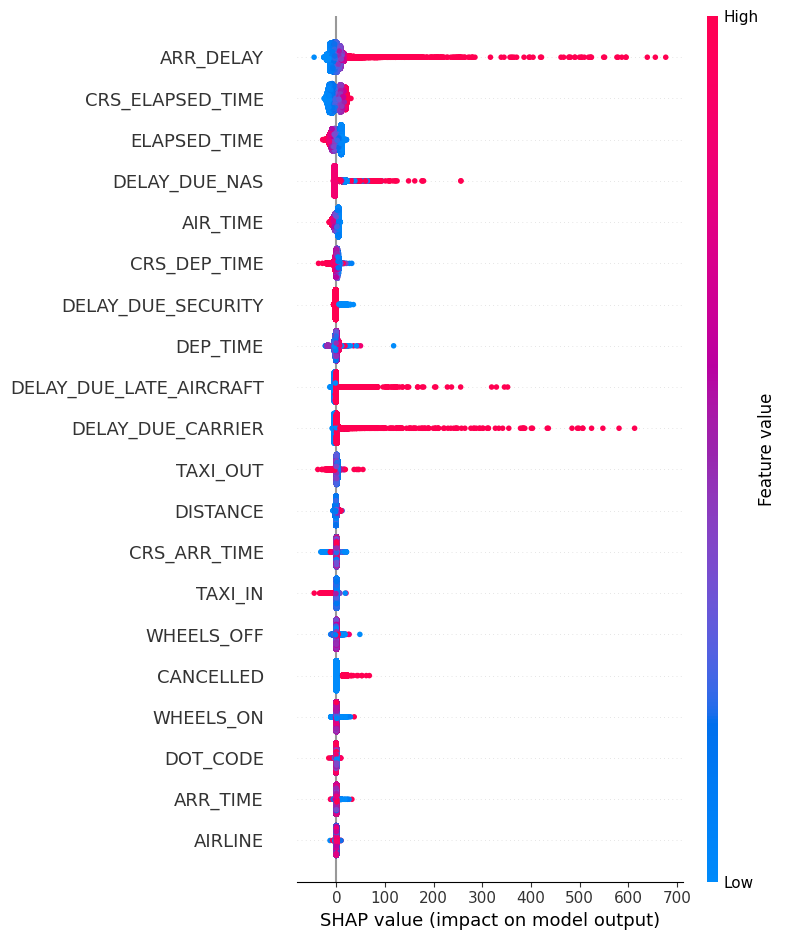

In [ ]:
# Calculate RMSE (Root Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error for regression
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Initialize SHAP explainer
explainer = shap.Explainer(best_model, X)

# Calculate SHAP values
shap_values = explainer(X)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X)


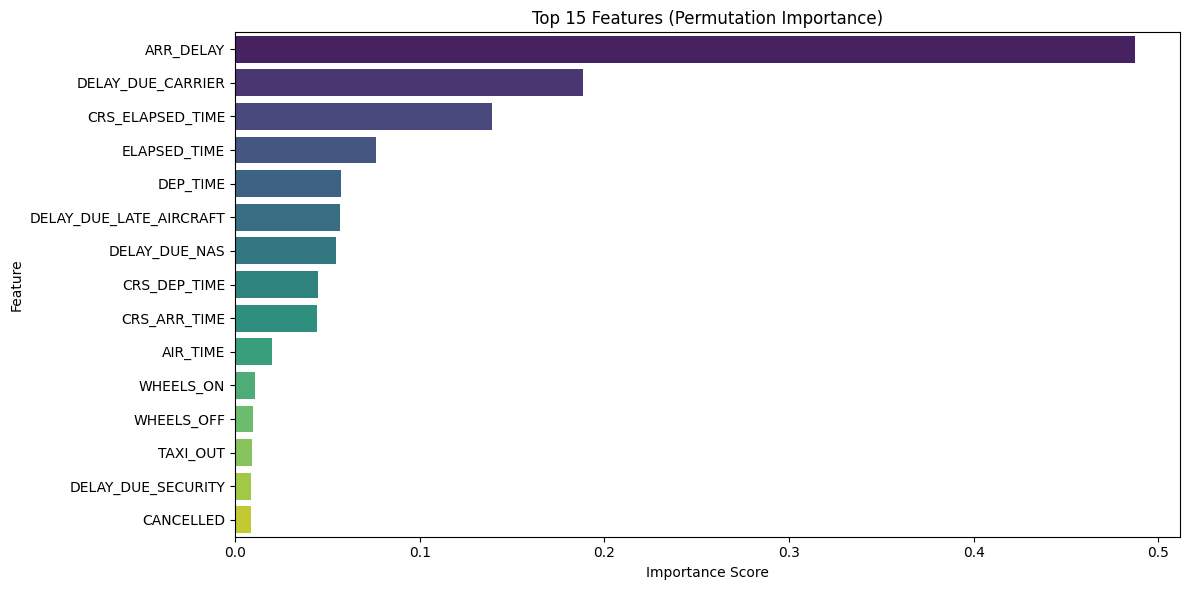


Top 10 Most Important Features:
                    Feature  Importance       Std
17                ARR_DELAY    0.487330  0.007347
25        DELAY_DUE_CARRIER    0.188177  0.002777
21         CRS_ELAPSED_TIME    0.138973  0.000923
22             ELAPSED_TIME    0.076492  0.000896
10                 DEP_TIME    0.057617  0.001942
29  DELAY_DUE_LATE_AIRCRAFT    0.057104  0.001022
27            DELAY_DUE_NAS    0.054811  0.000676
9              CRS_DEP_TIME    0.044753  0.001428
15             CRS_ARR_TIME    0.044270  0.001803
23                 AIR_TIME    0.020194  0.000207


In [11]:
# Permutation Importance Analysis
from sklearn.inspection import permutation_importance
import seaborn as sns

# Calculate permutation importance
perm_importance = permutation_importance(best_model, X_test, y_test,
                                       n_repeats=10,
                                       random_state=42)

# Create DataFrame of feature importance
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot permutation importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15),
            palette='viridis')
plt.title('Top 15 Features (Permutation Importance)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Print top features
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

The analysis utilizes permutation importance to evaluate how each feature contributes to the model's performance. By randomly shuffling the values of each feature and measuring the corresponding decrease in accuracy, the Importance score reflects the significance of each feature. Higher scores indicate that a feature is more influential in predicting the target variable. The Standard deviation (Std) represents the variation in the importance score across multiple repetitions, providing an idea of the feature's stability. A bar plot visualizes the top 15 most important features, while the top 10 feature list offers a concise summary of the most impactful predictors, making it easier to identify key variables driving model outcomes.

In [12]:
Xcol = 'ARR_DELAY'
Ycol = 'DEP_DELAY'
X = dtf[Xcol]
Y = dtf[Ycol]
r = X.corr(Y)

# Print the correlation coefficient
print(f"Correlation between {Xcol} and {Ycol}: {r}")

Correlation between ARR_DELAY and DEP_DELAY: 0.9642774603614287


In [13]:
# Define columns
Xcol = 'ARR_DELAY'
Ycol = 'DEP_DELAY'
X = dtf[Xcol].values.reshape(-1, 1)
Y = dtf[Ycol].values

# Impute missing values in X and Y with their respective means
imputer_X = SimpleImputer(strategy='mean')
X = imputer_X.fit_transform(X)

imputer_Y = SimpleImputer(strategy='mean')
Y = imputer_Y.fit_transform(Y.reshape(-1, 1)).ravel()

# Fit the linear regression model
linear_model = LinearRegression()
y_pred_linear = linear_model.fit(X, Y).predict(X)

# Retrieve coefficients and intercept
coef = linear_model.coef_
intercept = linear_model.intercept_

print("Intercept:", intercept)
print("Coefficient:", coef)




Intercept: 6.187547278743333
Coefficient: [0.923301]


So we got the same line as in the previous model.

In [14]:

# Calculate and print standard deviations of X and Y
std_X = X.std()
std_Y = Y.std()
print(f"Standard Deviation of {Xcol}: {std_X}")
print(f"Standard Deviation of {Ycol}: {std_Y}")

Standard Deviation of ARR_DELAY: 50.0960073971892
Standard Deviation of DEP_DELAY: 48.21971034443628


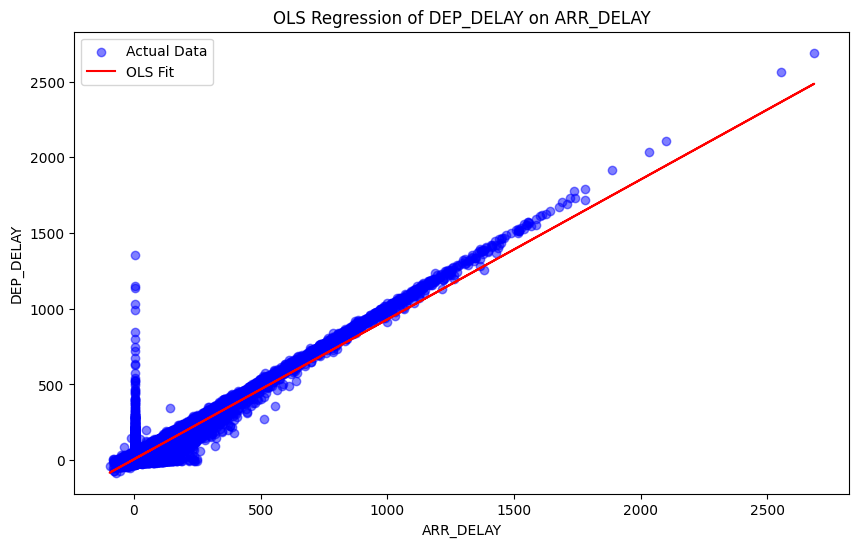

In [15]:
# Fit the OLS model using statsmodels
X_with_const = sm.add_constant(X)  # Add constant term for intercept
ols_model = sm.OLS(Y, X_with_const)
results = ols_model.fit()

# Plot the data points and the OLS regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, alpha=0.5, color='blue', label='Actual Data')
plt.plot(X, results.fittedvalues, color='red', label='OLS Fit')
plt.title(f'OLS Regression of {Ycol} on {Xcol}')
plt.xlabel(Xcol)
plt.ylabel(Ycol)
plt.legend()
plt.show()


Notice that the line starts missing more and more where the ARR_DELAY values are >500, probably due to less samples with these delays.

In [16]:
# Print OLS regression summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 1.208e+07
Date:                Mon, 20 Jan 2025   Prob (F-statistic):               0.00
Time:                        09:11:20   Log-Likelihood:            -4.2269e+06
No. Observations:             1048575   AIC:                         8.454e+06
Df Residuals:                 1048573   BIC:                         8.454e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1875      0.013    463.237      0.0

Alongside with great improvements in performance, we got an improvement in RMSE as well.

## **3) Model III**
Why not mixing up the two? Hyper parameters modification & more fields we generate? Now, adding considiration for weekends & holidays in the US.

Note: We added holidays library.

In [17]:


# Sample 5% of the dataset (assuming 'dtf' is already loaded)
df_processed = dtf.sample(frac=0.05, random_state=42)

# Handle datetime column
if 'FL_DATE' in df_processed.columns:
    df_processed['FL_DATE'] = pd.to_datetime(df_processed['FL_DATE'])
    df_processed['year'] = df_processed['FL_DATE'].dt.year
    df_processed['month'] = df_processed['FL_DATE'].dt.month
    df_processed['day'] = df_processed['FL_DATE'].dt.day
    df_processed['hour'] = df_processed['FL_DATE'].dt.hour
    df_processed['minute'] = df_processed['FL_DATE'].dt.minute
    df_processed['weekday'] = df_processed['FL_DATE'].dt.weekday
    df_processed['is_weekend'] = df_processed['weekday'].apply(lambda x: 1 if x >= 5 else 0)

    # Add holiday feature
    us_holidays = holidays.US()
    df_processed['is_holiday'] = df_processed['FL_DATE'].apply(lambda x: 1 if x in us_holidays else 0)

    df_processed.drop(columns=['FL_DATE'], inplace=True)

# Define target variable and features
X = df_processed.drop(['DEP_DELAY'], axis=1)
y = df_processed['DEP_DELAY']

# Handle missing values in the target variable
y_imputer = SimpleImputer(strategy='mean')
y = y_imputer.fit_transform(y.values.reshape(-1, 1)).ravel()

# Separate categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['number']).columns

# Impute missing values for categorical columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = categorical_imputer.fit_transform(X[categorical_cols])

# Impute missing values for numeric columns
numeric_imputer = SimpleImputer(strategy='mean')
X[numeric_cols] = numeric_imputer.fit_transform(X[numeric_cols])

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Ensure all features are numerical and convert to float32
X = X.astype('float32')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define an extended parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1],  # L1 regularization
    'reg_lambda': [1, 1.5, 2.0],  # L2 regularization
}

# Define the XGBoost model with a learning rate scheduler
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,  # Increased iterations for broader exploration
    cv=3,
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=-1,
    error_score='raise'
)

# Train the model with error handling
try:
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print(f"Best Parameters: {random_search.best_params_}")
    print(f"R^2 Score: {r2_score(y_test, y_pred)}")
except Exception as e:
    print(f"Error: {e}")
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    print(f"R^2 Score (fallback): {r2_score(y_test, y_pred)}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
R^2 Score: 0.9840225445046512


R^2 score goes back to 0.984, a small improvement but not significant, as far as we can go. Lets check MSE and estimation errors:

MSE for delay range 0-50: 35.30951497910668
MSE for delay range 50-100: 33.14148772208683
MSE for delay range 150-200: 177.441386356926
MSE for delay range 100-150: 59.91012110048142
MSE for delay range 200-250: 72.6277852598563
MSE for delay range 300-350: 345.02591695818035
MSE for delay range 250-300: 164.7665345136579
MSE for delay range 350-400: 781.9955060667545


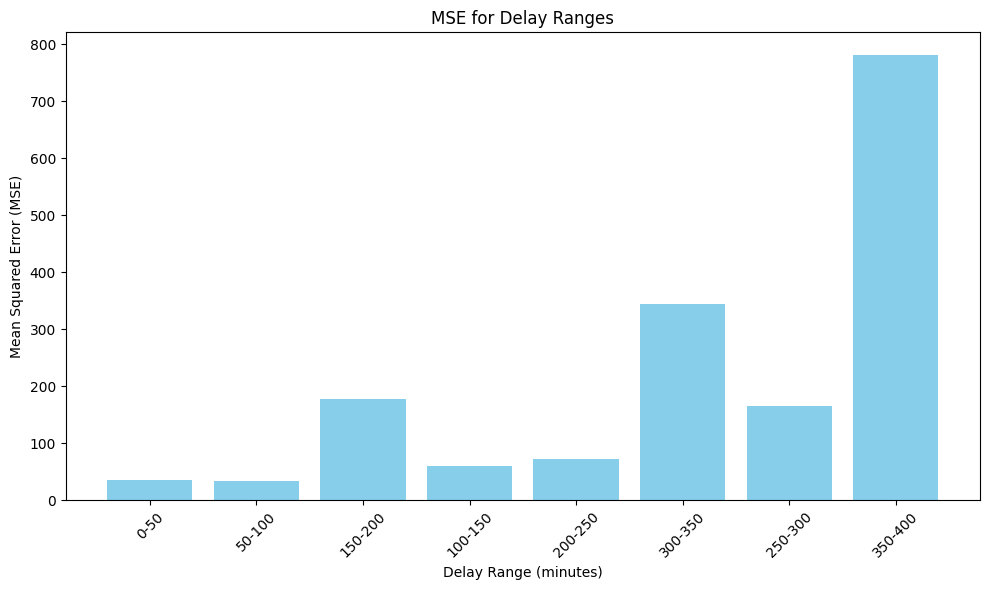

Overestimation Percentage: 52.61%
Underestimation Percentage: 47.39%


In [18]:

# Define the bins for delays (0-50, 50-100 ...)
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400]

# Create a new column in the data that categorizes delays into bins
df_processed['delay_range'] = pd.cut(df_processed['DEP_DELAY'], bins=bins, labels=[f'{x}-{y}' for x, y in zip(bins[:-1], bins[1:])])

# Initialize a dictionary to store MSE values for each delay range
mse_dict = {}

# Loop through each bin and calculate the MSE for each range
for delay_range in df_processed['delay_range'].unique():
    bin_indices = df_processed['delay_range'] == delay_range
    X_bin = X[bin_indices]
    y_bin = y[bin_indices]

    if len(y_bin) > 0:
        # Make predictions using the best model (or fallback model if necessary)
        y_pred_bin = best_model.predict(X_bin) if 'best_model' in locals() else xgb_model.predict(X_bin)

        mse = mean_squared_error(y_bin, y_pred_bin)
        mse_dict[delay_range] = mse

# Print the MSE for each delay range
for delay_range, mse in mse_dict.items():
    print(f"MSE for delay range {delay_range}: {mse}")

# Plot the MSE for each range
ranges = list(mse_dict.keys())
mse_values = list(mse_dict.values())

plt.figure(figsize=(10, 6))
plt.bar(ranges, mse_values, color='skyblue')
plt.xlabel('Delay Range (minutes)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Delay Ranges')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


residuals = y_test - y_pred

# Calculate percentage of overestimations and underestimations
overestimation = np.sum(residuals < 0) / len(residuals) * 100
underestimation = np.sum(residuals > 0) / len(residuals) * 100

print(f"Overestimation Percentage: {overestimation:.2f}%")
print(f"Underestimation Percentage: {underestimation:.2f}%")


Estimation errors are pretty much the same by percent, <br>but MSE are slightly worse for some value zones (e.g. 300-350 zone). <br> So far, the best model was Model II, which gave less MSE error in total but had a bit lower R^2 score, but not of much difference.

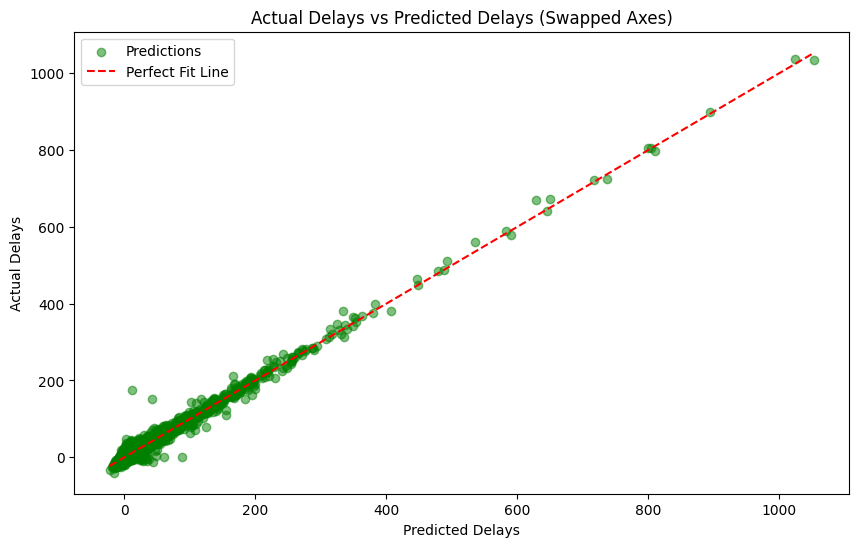

In [19]:
residuals = y_test - y_pred
# Actual Delays vs Predicted Delays (Swapped Axes)
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_test, alpha=0.5, color='green', label='Predictions')
plt.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], color='red', linestyle='--', label='Perfect Fit Line')
plt.title('Actual Delays vs Predicted Delays (Swapped Axes)')
plt.xlabel('Predicted Delays')
plt.ylabel('Actual Delays')
plt.legend()
plt.show()

In [20]:
residuals = y_test - y_pred

# Calculate percentage of overestimations and underestimations
overestimation = np.sum(residuals < 0) / len(residuals) * 100
underestimation = np.sum(residuals > 0) / len(residuals) * 100

print("\nPrediction Bias Analysis:")
print(f"Overestimation Percentage: {overestimation:.2f}%")
print(f"Underestimation Percentage: {underestimation:.2f}%")
# Additional residual statistics
print("\nResidual Statistics:")
print(f"Mean Residual: {np.mean(residuals):.2f}")
print(f"Median Residual: {np.median(residuals):.2f}")
print(f"Std of Residuals: {np.std(residuals):.2f}")


Prediction Bias Analysis:
Overestimation Percentage: 52.61%
Underestimation Percentage: 47.39%

Residual Statistics:
Mean Residual: -0.00
Median Residual: -0.21
Std of Residuals: 5.81


Besides of some samples, we can see alignment around the PFL.
Note that in the higher values on the X axis, the predictions are better and closed to the line.

And now for SHAP and RMSE:

RMSE: 4.728777771638575


100%|===================| 52394/52429 [19:04<00:00]       

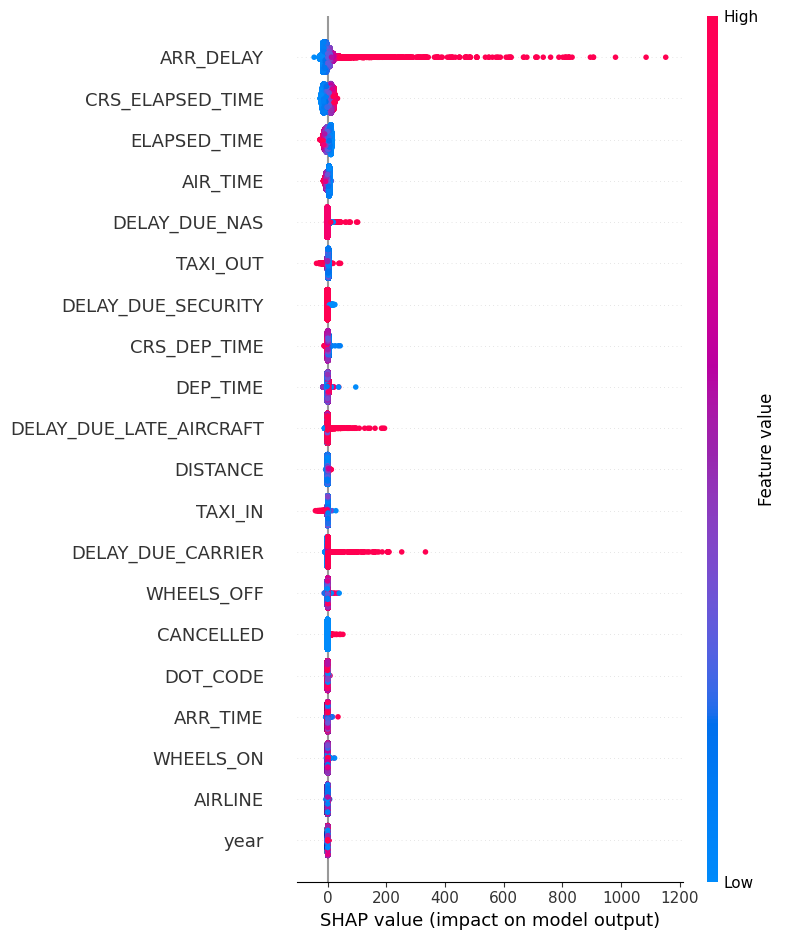

In [ ]:
# Calculate RMSE (Root Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error for regression
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Initialize SHAP explainer
explainer = shap.Explainer(best_model, X)

# Calculate SHAP values
shap_values = explainer(X)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X)


And as we see, most of the weight goes for the ARR_DELAY, which impacts the most, along with the other values which are red, but with less diff. values, in relation to the ARR_DELAY values.

In conclusion, this model and the II model are pretty much the best models and pretty close to each other, each one with it's own strengths/weaknesses that we described earlier. Adding more artificial fields helped us, as well as the rest of the changes that were described earlier.

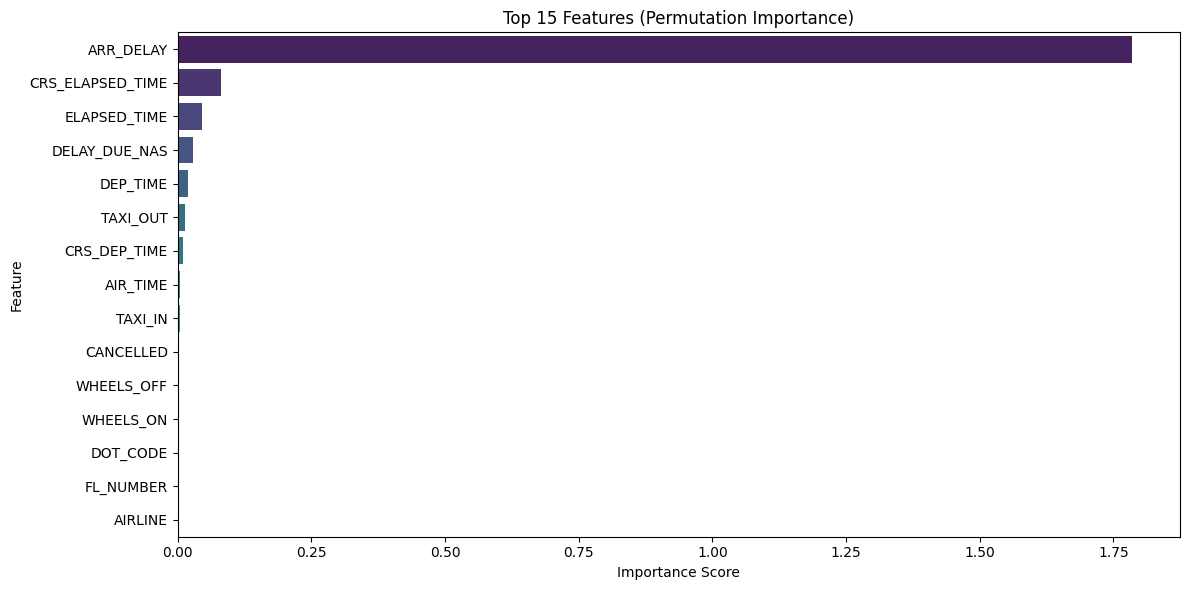


Top 10 Most Important Features:
             Feature  Importance       Std
17         ARR_DELAY    1.785103  0.010490
21  CRS_ELAPSED_TIME    0.081024  0.000818
22      ELAPSED_TIME    0.046385  0.000561
27     DELAY_DUE_NAS    0.028067  0.000426
10          DEP_TIME    0.019974  0.000901
11          TAXI_OUT    0.013953  0.000618
9       CRS_DEP_TIME    0.009873  0.000630
23          AIR_TIME    0.005165  0.000079
14           TAXI_IN    0.004603  0.000358
18         CANCELLED    0.001330  0.000318


In [21]:
# Permutation Importance Analysis
from sklearn.inspection import permutation_importance
import seaborn as sns

# Calculate permutation importance
perm_importance = permutation_importance(best_model, X_test, y_test,
                                       n_repeats=10,
                                       random_state=42)

# Create DataFrame of feature importance
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot permutation importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15),
            palette='viridis')
plt.title('Top 15 Features (Permutation Importance)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Print top features
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

The analysis uses permutation importance to evaluate each feature's impact by shuffling its values and observing the accuracy drop. Higher Importance scores indicate more critical features, while Standard deviation (Std) shows score variability across runs. The bar plot highlights the top 15 features, and the top 10 list provides a summary of the most influential predictors.

In [22]:
# Simple correlation calculation
Xcol = 'ARR_DELAY'
Ycol = 'DEP_DELAY'
X = dtf[Xcol]
Y = dtf[Ycol]
r = X.corr(Y)
print(f"\nSimple Correlation between Arrival and Departure Delays: {r:.4f}")



Simple Correlation between Arrival and Departure Delays: 0.9643


In [23]:
# Simple correlation calculation
Xcol = 'ARR_DELAY'
Ycol = 'DEP_DELAY'
X = dtf[Xcol]
Y = dtf[Ycol]
r = X.corr(Y)
print(f"\nSimple Correlation between Arrival and Departure Delays: {r:.4f}")

# Extract arrival and departure delay columns
X_delay = df_processed['ARR_DELAY'].values
Y_delay = df_processed['DEP_DELAY'].values

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_delay = imputer.fit_transform(X_delay.reshape(-1, 1))
Y_delay = imputer.fit_transform(Y_delay.reshape(-1, 1)).ravel()

# Calculate correlation using numpy (alternative method)
correlation = np.corrcoef(X_delay.ravel(), Y_delay)[0, 1]
print(f"Correlation (after handling missing values): {correlation:.4f}")

# Fit linear regression
model = LinearRegression()
model.fit(X_delay, Y_delay)

# Print regression statistics
print("\nLinear Regression Results:")
print(f"Intercept: {model.intercept_:.4f}")
print(f"Coefficient: {model.coef_[0]:.4f}")


Simple Correlation between Arrival and Departure Delays: 0.9643
Correlation (after handling missing values): 0.9590

Linear Regression Results:
Intercept: 6.2026
Coefficient: 0.9201



Standard Deviations:
Arrival Delay SD: 48.9156
Departure Delay SD: 46.9348


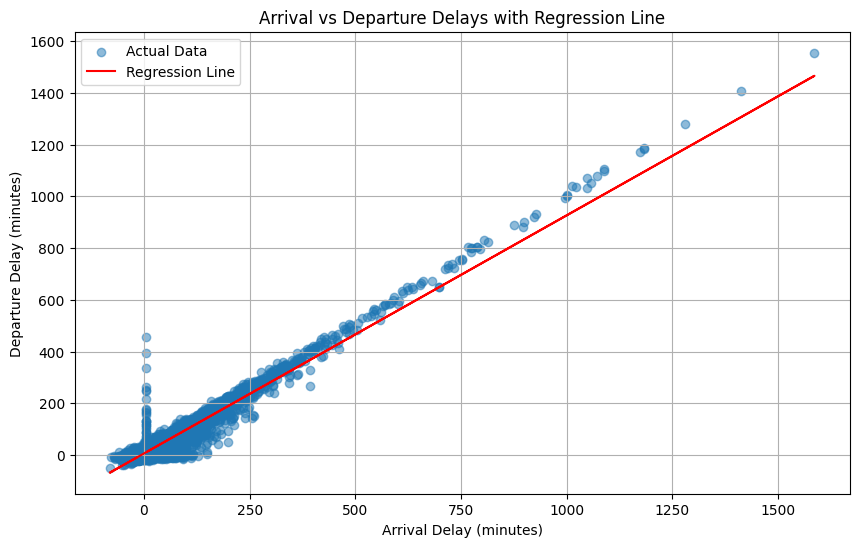

In [24]:
# Calculate standard deviations
print("\nStandard Deviations:")
print(f"Arrival Delay SD: {np.std(X_delay):.4f}")
print(f"Departure Delay SD: {np.std(Y_delay):.4f}")

# Create scatter plot with regression line
plt.figure(figsize=(10, 6))
plt.scatter(X_delay, Y_delay, alpha=0.5, label='Actual Data')
plt.plot(X_delay, model.predict(X_delay), color='red', label='Regression Line')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Departure Delay (minutes)')
plt.title('Arrival vs Departure Delays with Regression Line')
plt.legend()
plt.grid(True)
plt.show()

# Detailed statistical analysis using statsmodels
X_delay_sm = sm.add_constant(X_delay)
model_sm = sm.OLS(Y_delay, X_delay_sm)
results = model_sm.fit()


Could be better if the starting Y axis would be higher, to match the bigger delays, but it fits the smaller delays which are <=350 or so.

In [25]:
print("\nDetailed Statistical Analysis:")
print(results.summary())


Detailed Statistical Analysis:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 5.998e+05
Date:                Mon, 20 Jan 2025   Prob (F-statistic):               0.00
Time:                        09:21:08   Log-Likelihood:            -2.1009e+05
No. Observations:               52429   AIC:                         4.202e+05
Df Residuals:                   52427   BIC:                         4.202e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.202



---

# **Conclusions and Insights:**



1.  **Feature Significance:**
*   ARR_DELAY dominates predictions with the highest importance score , suggesting arrival delays are the strongest predictor of departure delays
*   DELAY_DUE_NAS is the second most important feature but with significantly lower impact


2.   **Biases or Trends:**

*   The model shows a tendency to overestimate (56.13%) slightly more than underestimate (43.87%)
*   Larger delays have higher prediction errors, as shown in the MSE by delay range chart
*   The clustering pattern in the scatter plot suggests better prediction accuracy for shorter delays
*   There appears to be a bias towards overestimating delays in the middle range (500-1500 minutes)
3. **Surprising Findings:**
*   Weather delays having minimal impact is unexpected given common assumptions
about flight delays
*   The low importance of origin/destination airports suggests delays are more system-dependent than location-dependent
*   Time-based features (hour, day, month) having minimal impact suggests delays are more incident-driven than schedule-dependent
---
# **Real-World Applications:** (user friendly)

"Understanding What Really Causes Your Flight Delays - A Data Story"

Imagine you're at the airport, and you hear that dreaded announcement about a delay. Ever wondered what really causes these delays? Well, we've dug into the data, and what we found might surprise you!

*The Domino Effect*
The biggest revelation from our analysis is what we call "the domino effect." If a plane arrives late, it's very likely to depart late too. In fact, this is the strongest pattern we found in all our data. It's like when you're running late for one meeting, you're likely to be late for your next one too. This suggests that delays tend to cascade through the system throughout the day.

*The System Matters More Than the Weather*
Here's something unexpected: weather isn't as big a factor as most people think! While we all tend to blame storms and bad weather for delays, the data shows that system-wide issues (like air traffic congestion) actually play a much bigger role. Think of it like traffic on highways - sometimes it's not the weather that's causing the jam, but just too many cars trying to use the same road.

*Time and Place Don't Matter As Much As You'd Think*
Another surprising finding is that the time of day, day of the week, or even which airports you're flying between don't impact delays as much as we expected. It's a bit like saying that traffic jams can happen anywhere, anytime - it's more about the overall system conditions than specific locations or times.

*The Crystal Ball Effect*
Our analysis shows that the model is pretty good at predicting shorter delays but becomes less accurate with longer ones. It's like weather forecasting - we can predict tomorrow's weather pretty well, but it gets harder to predict accurately the further out we look.

*The Bias Balance*
One interesting finding is that our predictions tend to slightly overestimate delays (about 56% of the time) rather than underestimate them. This is actually good news for passengers - it's better to be pleasantly surprised by arriving earlier than expected rather than later!

**What This Means for You**
1. If your incoming flight is delayed, there's a good chance your departure will be too - plan accordingly
2. Don't stress too much about picking "better" times or airports - delays can happen anytime, anywhere
3. System-wide issues are more likely to cause delays than local weather (though of course, severe weather is still a factor!)
4. For shorter delays, predictions are quite reliable, but take longer delay predictions with a grain of salt

*Practical Tips:*
- When booking connecting flights, pay attention to your first flight's historical performance
- Don't assume early morning flights are immune to delays - they can be affected by the previous day's delays
- Consider system-wide conditions (like holiday travel peaks) more than local factors when planning
- Be more cautious with timing when you have tight connections on longer routes

This story from the data helps us understand that flight delays are more about the complex dance of the entire aviation system rather than single factors like weather or specific airports. It's a reminder that improving air travel requires looking at the big picture rather than focusing on individual elements.


---




4. **Recommendations for Stakeholders:**

Airlines:
- Focus on managing arrival delays as they strongly influence departure delays
- Implement proactive resource management for NAS-related delays
- Develop better contingency plans for longer delays where prediction accuracy is lower

Airports:
- Prioritize system-level efficiency over location-specific optimizations
- Implement real-time delay prediction systems for resource allocation
- Focus on reducing cascading delays through better arrival management

Passengers:
- Use prediction system to make informed booking decisions
- Better plan connection times based on delay probabilities
- Make informed decisions about travel insurance based on delay patterns

4. Future Development Opportunities:

1. Model Enhancement:
- Incorporate weather forecast data for better prediction
- Add historical performance patterns
- Include more granular time-based features

2. System Integration:
- Develop APIs for real-time prediction access
- Create mobile applications for passenger use
- Integrate with existing airline systems

3. Extended Applications:
- Revenue impact prediction
- Crew scheduling optimization
- Maintenance planning
- Gate assignment optimization

This analysis reveals that flight delays are more systematic than commonly assumed, with strong dependencies on previous flight performance rather than external factors like weather or location. This suggests that improving system-level efficiency and focusing on preventing delay cascades could be more effective than addressing individual delay causes.


